# Configs and Imports

In [ ]:
# === Cell 1 — Imports, config, robust helpers ===
import os, glob, math, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12,4)
np.random.seed(42)

CORE_COLS = ["timestamp","RPM","SPEED","THROTTLE_POS","MAF","ENGINE_LOAD"]
KMH_TO_MS = 1000.0/3600.0

def ensure_dt(s): return pd.to_datetime(s, errors="coerce", utc=True)

def infer_base_interval_seconds(ts: pd.Series) -> float:
    if ts.size < 2: return 1.0
    d = ts.sort_values().diff().dropna().dt.total_seconds()
    d = d[d>0]
    if d.empty: return 1.0
    q05,q95 = d.quantile([0.05,0.95])
    core = d[(d>=q05)&(d<=q95)]
    rounded = (core/0.01).round()*0.01
    mode = rounded.mode()
    return float(mode.iloc[0] if not mode.empty else core.median())

def rows_for(seconds, dt): return max(3, int(round(seconds/max(dt,1e-3))))

def run_lengths(mask: np.ndarray):
    m = mask.astype(bool)
    idx = np.flatnonzero(np.diff(np.r_[False, m, False]))
    starts, ends = idx[::2], idx[1::2]
    return starts, (ends - starts)

def safe_num(df, cols):
    for c in cols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def robust_scale_01(s):
    rs = RobustScaler().fit_transform(s.values.reshape(-1,1)).ravel()
    return np.clip(MinMaxScaler().fit_transform(rs.reshape(-1,1)).ravel(), 0, 1)

# Data

In [ ]:
# === Cell 2 — Merge many CSVs, segment drives, clean + dynamics ===
CSV_PATTERN = "*.csv"
files = sorted(glob.glob(CSV_PATTERN))
if not files: raise FileNotFoundError("No CSV files matched. Set CSV_PATTERN.")

dfs = []
for fp in files:
    df = pd.read_csv(fp)
    keep = [c for c in CORE_COLS if c in df.columns]
    df = df[keep].copy()
    df["source_file"] = os.path.basename(fp)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df["timestamp"] = ensure_dt(df["timestamp"])
df = safe_num(df, [c for c in CORE_COLS if c!="timestamp"])
df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

# segment drives by gaps (>5 min) or file switch
gap_sec = 5*60
dt = df["timestamp"].diff().dt.total_seconds().fillna(0)
new_drive = (dt > gap_sec) | (df["source_file"].ne(df["source_file"].shift()))
df["drive_id"] = new_drive.cumsum()

# impute missing numeric
num_cols = [c for c in df.columns if c not in ["timestamp","source_file","drive_id"]]
df[num_cols] = KNNImputer(n_neighbors=3).fit_transform(df[num_cols])

# base cadence + dynamics
base_sec = infer_base_interval_seconds(df["timestamp"])
df["SPEED_ms"] = df["SPEED"]*KMH_TO_MS
df["ACCEL"] = df["SPEED_ms"].diff()/max(base_sec,1e-3)                 # m/s^2
df["JERK"]  = df["ACCEL"].diff()/max(base_sec,1e-3)                     # m/s^3

# rolling windows
W5, W10 = rows_for(5, base_sec), rows_for(10, base_sec)
for col in ["SPEED_ms","RPM","ENGINE_LOAD","THROTTLE_POS","MAF","ACCEL","JERK"]:
    if col not in df.columns: continue
    df[f"{col}_mean_w5"] = df[col].rolling(W5, min_periods=1).mean()
    df[f"{col}_std_w5"]  = df[col].rolling(W5, min_periods=1).std()
    df[f"{col}_mean_w10"] = df[col].rolling(W10, min_periods=1).mean()
    df[f"{col}_std_w10"]  = df[col].rolling(W10, min_periods=1).std()

# distance estimate (meters)
dt_s = df["timestamp"].diff().dt.total_seconds().fillna(0).clip(lower=0, upper=10*base_sec)
df["dist_m"] = (df["SPEED_ms"] * dt_s).fillna(0)
print(f"Files: {len(files)} | Drives: {df['drive_id'].nunique()} | Rows: {len(df):,}")
df.head(3)

Files: 10 | Drives: 10 | Rows: 2,378


,timestamp,RPM,SPEED,THROTTLE_POS,MAF,ENGINE_LOAD,source_file,drive_id,SPEED_ms,ACCEL,...,MAF_std_w10,ACCEL_mean_w5,ACCEL_std_w5,ACCEL_mean_w10,ACCEL_std_w10,JERK_mean_w5,JERK_std_w5,JERK_mean_w10,JERK_std_w10,dist_m
0,2025-09-28 13:28:43.286472+00:00,766.25,0.0,12.54902,4.55,2.352941,obd_data_log_20250928_132843.csv,1,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2025-09-28 13:28:44.710016+00:00,755.75,0.0,12.54902,4.49,2.352941,obd_data_log_20250928_132843.csv,1,0.0,0.0,...,0.042426,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
2,2025-09-28 13:28:46.085703+00:00,768.25,0.0,12.54902,4.54,2.352941,obd_data_log_20250928_132843.csv,1,0.0,0.0,...,0.032146,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0


# Fleeth threshold + Idle

ACCEL_thr=2.56 m/s^2  |  JERK_thr=7.89 m/s^3


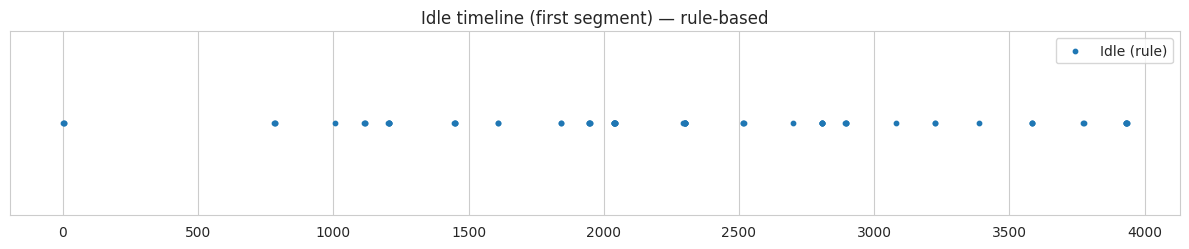

count    10.000000
mean      0.029653
std       0.014866
min       0.012195
25%       0.015959
50%       0.031526
75%       0.037927
max       0.059259
Name: idle_frac, dtype: float64


In [ ]:
# === Cell 3 — Fleet thresholds + RULE Idle mask (patched) ===
from sklearn.linear_model import LinearRegression
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy.signal import medfilt

# 1) Build per-drive aggregates (length-invariant)
def run_lengths(mask: np.ndarray):   # <— was _run_lengths; rename to match calls below
    m = mask.astype(bool)
    idx = np.flatnonzero(np.diff(np.r_[False, m, False]))
    return idx[::2], idx[1::2] - idx[::2]

base_sec  = infer_base_interval_seconds(df["timestamp"])
thr_accel = max(0.6, df["ACCEL"].abs().quantile(0.85))
thr_jerk  = max(0.6, df["JERK"].abs().quantile(0.90))
sharp_mask = (df["ACCEL"].abs()>thr_accel) | (df["JERK"].abs()>thr_jerk)

print(f"ACCEL_thr={thr_accel:.2f} m/s^2  |  JERK_thr={thr_jerk:.2f} m/s^3")

# Idle: near-zero motion + minimal throttle/load/MAF (no ML)
speed_low = (df["SPEED_ms"].abs() <= 0.6)  # ~<= 2.2 km/h
thr_low   = (df["THROTTLE_POS"] <= df["THROTTLE_POS"].quantile(0.10)) if "THROTTLE_POS" in df else True
load_low  = (df["ENGINE_LOAD"]  <= df["ENGINE_LOAD"].quantile(0.15))  if "ENGINE_LOAD"  in df else True
maf_low   = (df["MAF"]          <= df["MAF"].quantile(0.10))          if "MAF"          in df else True
accel_low = (df["ACCEL"].abs()  <= df["ACCEL"].abs().quantile(0.20))

idle_rule = (speed_low & thr_low & load_low & maf_low & accel_low).astype(bool)

# debounce small flicker
df["IDLE_RULE"] = medfilt(idle_rule.astype(int), kernel_size=5).astype(bool)

# quick sanity plot
plt.figure(figsize=(12,2.6))
N = min(2500, len(df))
t0 = (df["timestamp"].iloc[:N]-df["timestamp"].iloc[0]).dt.total_seconds()
plt.scatter(t0[df["IDLE_RULE"].iloc[:N]], np.zeros(df["IDLE_RULE"].iloc[:N].sum())+0.5, s=10, label="Idle (rule)")
plt.yticks([]); plt.title("Idle timeline (first segment) — rule-based"); plt.legend(); plt.tight_layout(); plt.show()

# per-drive idle summary (used later)
idle_frac = df.groupby("drive_id")["IDLE_RULE"].mean().rename("idle_frac")
idle_dur_s = []
for gid, g in df.groupby("drive_id"):
    starts, lens = run_lengths(g["IDLE_RULE"].values)  # <— now matches definition
    idle_dur_s.append(pd.Series({
        "drive_id": gid,
        "idle_episodes": len(lens),
        "idle_median_dur_s": float(np.median(lens)*base_sec if len(lens) else 0.0)
    }))
idle_dur_s = pd.DataFrame(idle_dur_s).set_index("drive_id")

print(idle_frac.describe())

# Algorithmic efficiency

Learned weights: {'p_freq': np.float64(0.002), 'p_dur': np.float64(0.177), 'p_mag': np.float64(0.0), 'p_idle': np.float64(0.0), 'p_cv': np.float64(0.0), 'p_rpm': np.float64(0.191), 'p_maf': np.float64(0.094)}
Weights (opt with MAF/RPM): {'p_freq': np.float64(0.002), 'p_dur': np.float64(0.177), 'p_mag': np.float64(0.0), 'p_idle': np.float64(0.0), 'p_cv': np.float64(0.0), 'p_rpm': np.float64(0.191), 'p_maf': np.float64(0.094)}
Efficiency range: 67.49 → 83.17


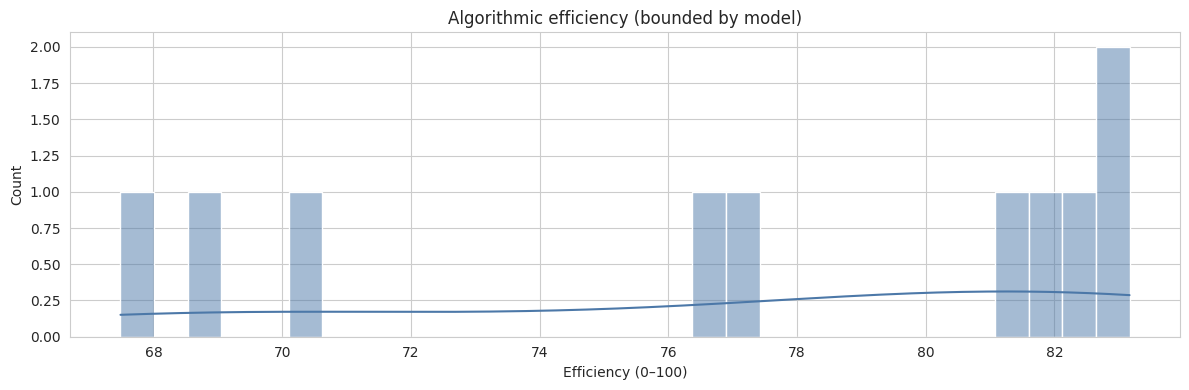

,duration_min,distance_km,freq_pm,dur_frac,sharp_mag,idle_frac,idle_med_s,idle_epm,speed_cv,frac_rpm90,...,proxy,ineff_model,efficiency_algo,p_freq,p_dur,p_mag,p_idle,p_cv,p_rpm,p_maf
drive_id,,,,,,,,,,,,,,,,,,,,,
1,2.458542,2.416524,17.083292,0.308448,0.518452,0.015873,1.95,0.406745,0.241577,0.052910,...,0.196296,0.311257,68.874253,0.884028,0.826427,0.531375,0.585077,0.362415,0.795009,0.775653
2,3.134787,2.416456,6.061018,0.141690,0.721930,0.012195,1.95,0.319001,0.185610,0.024390,...,0.089837,0.231316,76.868438,0.311512,0.488368,0.844244,0.577777,0.105226,0.618245,0.615414
3,3.337046,2.417647,7.191989,0.103884,0.485764,0.034615,1.95,0.898999,0.262189,0.000000,...,0.030385,0.168329,83.167083,0.376771,0.398705,0.468625,0.630207,0.503834,0.434202,0.318954
4,2.704575,2.415658,10.722572,0.196272,0.637356,0.028436,1.95,0.739488,0.261099,0.009479,...,0.096445,0.230216,76.978434,0.599013,0.617624,0.738829,0.614649,0.496166,0.506377,0.578304
5,3.364225,2.419536,8.917358,0.151347,0.455278,0.059259,3.25,0.891736,0.310562,0.000000,...,0.043333,0.184977,81.502330,0.484707,0.511632,0.410943,0.705416,0.798527,0.434202,0.318954


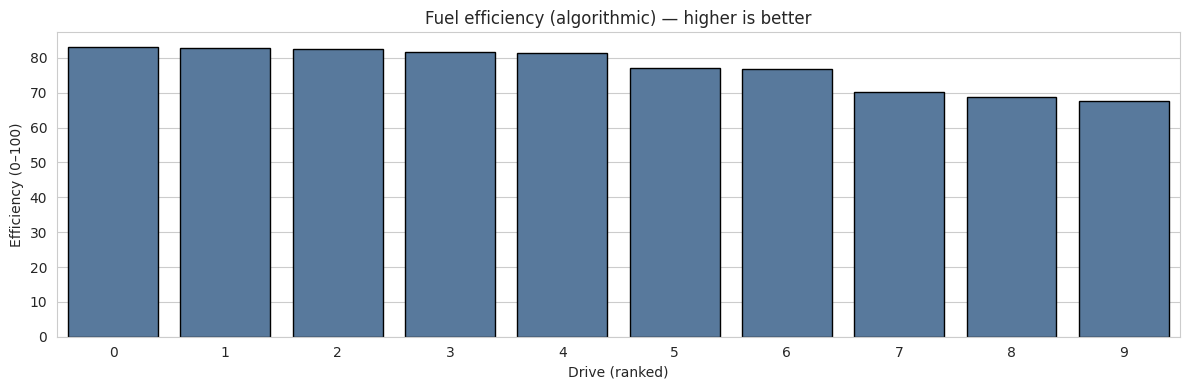

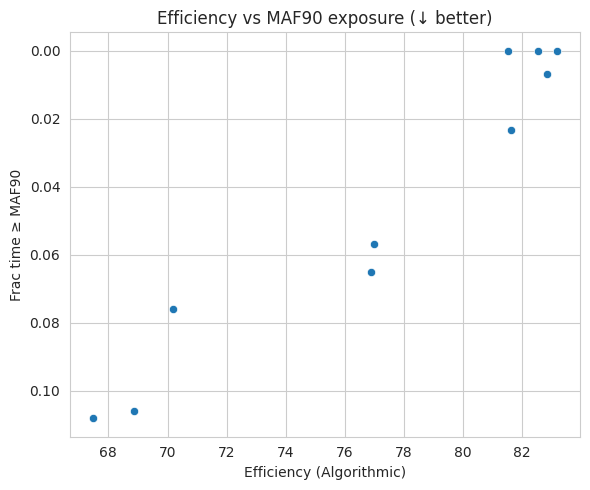

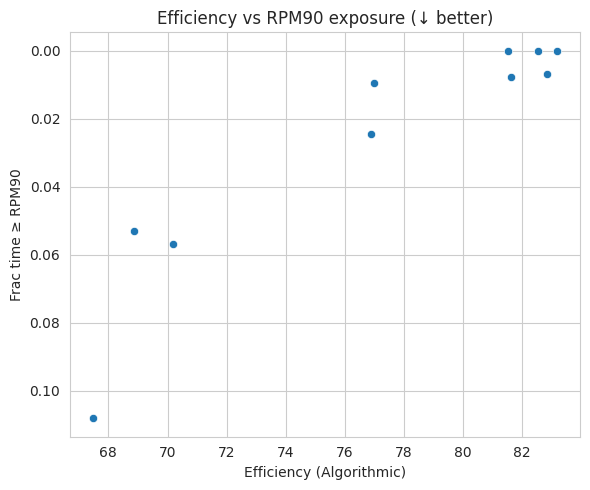

In [ ]:
drv = []

# target high contributed vars
thr_rpm90 = g["RPM"].quantile(0.90) if "RPM" in df.columns else np.nan
thr_maf90 = g["MAF"].quantile(0.90) if "MAF" in df.columns else np.nan

for gid, g in df.groupby("drive_id", sort=True):
    if len(g) < 5:
        continue
    dt_s = g["timestamp"].diff().dt.total_seconds().fillna(0).clip(lower=0, upper=10*base_sec)
    T = float(dt_s.sum()); mins = max(1e-6, T/60)
    # sharp episodes
    s = sharp_mask.loc[g.index].values
    st, ln = run_lengths(s)
    # frequency/duration
    freq_pm = len(ln)/mins
    dur_frac = (ln.sum()*base_sec)/max(1e-6, T)
    # sharpness magnitude (episode peak-over-threshold, capped; sharpness not over-penalized)
    peaks = []
    for a,b in zip(st, ln):
        seg = g.iloc[a:a+b]
        pa, pj = float(seg["ACCEL"].abs().max()), float(seg["JERK"].abs().max())
        over_a = max(0.0, (pa-thr_accel)/thr_accel)
        over_j = max(0.0, (pj-thr_jerk)/thr_jerk)
        peaks.append(min(1.5, 0.7*over_a + 0.3*over_j))
    sharp_mag = float(np.mean(peaks)) if peaks else 0.0
    # idle signals
    idle_frac = float(g["IDLE_RULE"].mean())
    sti, lni = run_lengths(g["IDLE_RULE"].values)
    idle_med_s = float(np.median(lni)*base_sec if len(lni) else 0.0)
    idle_epm = len(lni)/mins
    # speed steadiness
    sp_cv = float((g["SPEED_ms_std_w10"]/(g["SPEED_ms_mean_w10"]+1e-6)).mean())

    # fuel-demand proxies (targets for weight learning)
    # frac_maf90  = g["MAF"].ge(df["MAF"].quantile(0.90)).mean() if "MAF" in g else 0.0 # Use direct component on top
    frac_load85 = g["ENGINE_LOAD"].ge(df["ENGINE_LOAD"].quantile(0.85)).mean() if "ENGINE_LOAD" in g else 0.0
    frac_thr85  = g["THROTTLE_POS"].ge(df["THROTTLE_POS"].quantile(0.85)).mean() if "THROTTLE_POS" in g else 0.0

    # high contributive vars
    frac_rpm90 = float((g["RPM"] >= thr_rpm90).mean()) if "RPM" in g.columns and not np.isnan(thr_rpm90) else 0.0
    frac_maf90 = float((g["MAF"] >= thr_maf90).mean()) if "MAF" in g.columns and not np.isnan(thr_maf90) else 0.0

    drv.append({
        "drive_id":gid,"duration_min":mins,"distance_km":g["dist_m"].sum()/1000.0,
        "freq_pm":freq_pm,"dur_frac":dur_frac,"sharp_mag":sharp_mag,
        "idle_frac":idle_frac,"idle_med_s":idle_med_s,"idle_epm":idle_epm,"speed_cv":sp_cv,
        "frac_rpm90": frac_rpm90,
        "frac_maf90": frac_maf90,

        # proxy for learning weights (higher proxy ⇒ more fuel demand)
        # OLD proxy
        # "proxy": (
        #   0.40*frac_maf90 +
        #   0.30*frac_load85 +
        #   0.15*frac_thr85 +
        #   0.15*idle_frac
        #)
        # NEW proxy
        "proxy": (
            0.80*frac_rpm90 +     # ↑ RPM influence
            0.60*frac_maf90 +     # ↑ MAF influence
            0.15*frac_load85 +
            0.10*frac_thr85 +
            0.10*idle_frac
        )
    })
dfeat = pd.DataFrame(drv).set_index("drive_id")

# 2) Smooth, bounded penalties per component via sigmoids (data-driven centers/slopes)
def sigmoid(x): return 1/(1+np.exp(-x))
def penalty(series):
    q25, q50, q75 = np.quantile(series, [0.25,0.50,0.75])
    s = (q75 - q25)/1.349 if (q75>q25) else max(1e-6, series.std())
    return sigmoid((series - q50)/max(1e-6, s))

P = pd.DataFrame({
    "p_freq": penalty(dfeat["freq_pm"]),
    "p_dur":  penalty(dfeat["dur_frac"]),
    "p_mag":  penalty(dfeat["sharp_mag"]),
    "p_idle": sigmoid( 0.7*(penalty(dfeat["idle_frac"])) + 0.3*(penalty(dfeat["idle_med_s"])) ),
    "p_cv":   penalty(dfeat["speed_cv"]),
    "p_rpm":  penalty(dfeat["frac_rpm90"]),
    "p_maf":  penalty(dfeat["frac_maf90"])
}, index=dfeat.index)

# 3) Learn weights (non-negative) against proxy by fitting the exponential combiner:
#    ineff_hat = 1 - exp(-P @ w)  ⇒  -log(1 - proxy_clip) ≈ P @ w
proxy = dfeat["proxy"].clip(0, 1-1e-6)                 # keep in (0,1)
target_lin = -np.log(1 - proxy)                           # invert combiner
lr = LinearRegression(positive=True).fit(P.values, target_lin.values)
w = lr.coef_
dfeat["ineff_model"] = 1 - np.exp(-P.values @ w)       # in (0,1)

# 4) Final efficiency (bounded; no batch min-max)
dfeat["efficiency_algo"] = 100*(1 - dfeat["ineff_model"])
ranked = dfeat.sort_values("efficiency_algo", ascending=False)

# 5) Diagnostics
print("Learned weights:", dict(zip(P.columns, np.round(w,3))))
print("Weights (opt with MAF/RPM):", {k: round(v,3) for k, v in dict(zip(P.columns, w)).items()})
print("Efficiency range:", round(dfeat["efficiency_algo"].min(),2), "→", round(dfeat["efficiency_algo"].max(),2))

plt.figure(figsize=(12,4))
sns.histplot(dfeat["efficiency_algo"], bins=30, kde=True, color="#4C78A8")
plt.title("Algorithmic efficiency (bounded by model)"); plt.xlabel("Efficiency (0–100)")
plt.tight_layout(); plt.show()

# Keep a merged per-drive table for ML training in Cell B
per_drive = dfeat.join(P)
display(per_drive.head(5))

# Plot
plt.figure(figsize=(12,4))
sns.barplot(x=np.arange(len(ranked)), y=ranked["efficiency_algo"], color="#4C78A8", edgecolor="black")
plt.title("Fuel efficiency (algorithmic) — higher is better"); plt.xlabel("Drive (ranked)"); plt.ylabel("Efficiency (0–100)")
plt.tight_layout(); plt.show()

# RPM/MAF boosting viz
plt.figure(figsize=(6,5))
sns.scatterplot(x=dfeat["efficiency_algo"], y=dfeat["frac_maf90"], s=35)
plt.gca().invert_yaxis(); plt.title("Efficiency vs MAF90 exposure (↓ better)")
plt.xlabel("Efficiency (Algorithmic)"); plt.ylabel("Frac time ≥ MAF90"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x=dfeat["efficiency_algo"], y=dfeat["frac_rpm90"], s=35)
plt.gca().invert_yaxis(); plt.title("Efficiency vs RPM90 exposure (↓ better)")
plt.xlabel("Efficiency (Algorithmic)"); plt.ylabel("Frac time ≥ RPM90"); plt.tight_layout(); plt.show()


# Shading + Sharp episode

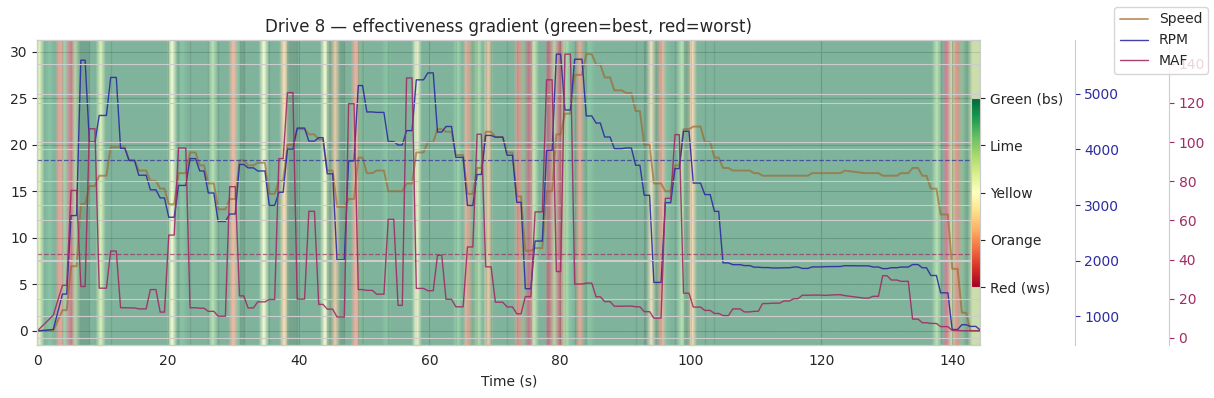

,peak_over_thr,dur_s
count,29.000000,29.000000
mean,2.080459,1.344828
std,0.830496,0.934397
min,1.000000,0.650000
25%,1.333333,0.650000
50%,1.999999,0.650000
75%,2.499999,1.950000
max,3.999998,3.250000


In [ ]:
# === Cell 5 — Inspect a drive: timeline with HIGH-CONTRAST effectiveness gradient + sharp episode stats ===
if len(ranked) == 0:
    raise RuntimeError("No drives scored.")

drive_to_show = int(ranked.tail(1).index[0])
g = df[df["drive_id"] == drive_to_show].copy()
t = (g["timestamp"] - g["timestamp"].iloc[0]).dt.total_seconds()

g_sharp = (g["ACCEL"].abs() > thr_accel) | (g["JERK"].abs() > thr_jerk)
ineff_zone = g_sharp | g["IDLE_RULE"]

# Accel and jerk computed
A = g["ACCEL"].abs()
J = g["JERK"].abs()
a_lo, a_hi = np.nanquantile(A, [0.75, 0.95]) if A.notna().any() else (0.0, 1.0)
j_lo, j_hi = np.nanquantile(J, [0.75, 0.95]) if J.notna().any() else (0.0, 1.0)
a_span = max(1e-6, a_hi - a_lo); j_span = max(1e-6, j_hi - j_lo)

# Efficient color grading
sev_a = np.clip((A - a_lo) / a_span, 0, 1)
sev_j = np.clip((J - j_lo) / j_span, 0, 1)
idle   = g["IDLE_RULE"].astype(float)
ineff_raw = 0.45*sev_a + 0.25*sev_j + 0.30*idle

focus = ineff_raw.where(ineff_zone, np.nan).dropna()
q_lo, q_hi = (np.nanquantile(focus, [0.15, 0.98]) if len(focus) > 0
              else np.nanquantile(ineff_raw, [0.15, 0.98]))
span = max(1e-6, q_hi - q_lo)
ineff01 = np.clip((ineff_raw - q_lo) / span, 0, 1)
GAMMA = 0.999
effectiveness = (1.0 - ineff01) ** GAMMA

# ----  shader plot ----
import matplotlib as mpl

# Fleet-wide thresholds (fallback to local if unavailable)
try:
    rpm90_thr = thr["RPM90"]
except Exception:
    rpm90_thr = (np.nanquantile(df["RPM"], 0.90) if "RPM" in df else np.nan)

try:
    maf90_thr = thr["MAF90"]
except Exception:
    maf90_thr = (np.nanquantile(df["MAF"], 0.90) if "MAF" in df else np.nan)

fig, ax1 = plt.subplots(figsize=(12, 4))

# Left axis: SPEED
l_speed = ax1.plot(t, g["SPEED_ms"], color="#a0662c", alpha=0.65, label="Speed", linewidth=1.4, zorder=3)[0]

# First right axis: THROTTLE
# ax_thr = ax1.twinx()
# l_thr  = ax_thr.plot(t, g["THROTTLE_POS"], color="#D62728", alpha=0.65, label="Throttle", zorder=3)[0]
# ax1.set_ylabel("Speed (m/s)")                      # Hide legent title for space
# ax_thr.set_ylabel("Throttle (%)")                  # Hide legent title for space

# --- Add a second and third right axis (offset spines) for RPM & MAF ---
def _make_twin(ax, offset):
    ax_new = ax.twinx()
    ax_new.spines["right"].set_position(("axes", offset))
    # Matplotlib trick to make extra right spine visible
    ax_new.spines["right"].set_visible(True)
    return ax_new

ax_rpm = _make_twin(ax1, 1.10)   # RPM axis (right, slight offset)
ax_maf = _make_twin(ax1, 1.20)   # MAF axis (right, further offset)

# RPM line + RPM90 guide
lines = [l_speed]#, l_thr]
if "RPM" in g:
    l_rpm = ax_rpm.plot(t, g["RPM"], color="#2c2ca0", linewidth=1.0, alpha=0.9, label="RPM")[0]
    if not np.isnan(rpm90_thr):
        ax_rpm.axhline(rpm90_thr, color="#2c2ca0", linestyle="--", linewidth=0.9, alpha=0.7)
    # ax_rpm.set_ylabel("RPM", color="#2c2ca0")      # Hide legent title for space
    ax_rpm.tick_params(axis='y', colors="#2c2ca0")
    lines.append(l_rpm)

# MAF line + MAF90 guide
if "MAF" in g:
    l_maf = ax_maf.plot(t, g["MAF"], color="#a02c66", linewidth=1.0, alpha=0.9, label="MAF")[0]
    if not np.isnan(maf90_thr):
        ax_maf.axhline(maf90_thr, color="#a02c66", linestyle="--", linewidth=0.9, alpha=0.7)
    # ax_maf.set_ylabel("MAF", color="#a02c66")      # Hide legent title for space
    ax_maf.tick_params(axis='y', colors="#a02c66")
    lines.append(l_maf)

# --- effectiveness gradient background & inefficient zone shading ---
ymin, ymax = ax1.get_ylim()
grad = np.tile(effectiveness.to_numpy(), (128, 1))
ax1.imshow(
    grad, extent=[t.min(), t.max(), ymin, ymax],
    cmap="RdYlGn", aspect="auto", interpolation="bilinear",
    alpha=0.50, vmin=0, vmax=1, origin="lower", zorder=1
)
ax1.fill_between(t, ymin, ymax, where=ineff_zone.values,
                 color="black", alpha=0.08, step="pre", zorder=2)

ax1.set_title(f"Drive {drive_to_show} — effectiveness gradient (green=best, red=worst)")
ax1.set_xlabel("Time (s)")

# --- legends (collect all available lines) ---
labels = [ln.get_label() for ln in lines]
fig.legend(lines, labels, loc="upper right")

# ----  colorbar placement ----
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = mpl.cm.ScalarMappable(cmap="RdYlGn", norm=norm); sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, pad=0.01, fraction=0.01, aspect=20)
# cbar.set_label("Effectiveness", labelpad=10).      # Hide legent title for space
cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
cbar.set_ticklabels(["Red (ws)", "Orange", "Yellow", "Lime", "Green (bs)"])

plt.tight_layout()
plt.show()

# --- sharp episode table ---
starts, lens = run_lengths(g_sharp.values)
peaks, kinds = [], []
for st, ln in zip(starts, lens):
    seg = g.iloc[st:st+ln]
    pa, pj = float(seg["ACCEL"].abs().max()), float(seg["JERK"].abs().max())
    peaks.append(max(pa / (thr_accel + 1e-6), pj / (thr_jerk + 1e-6)))
    kinds.append("accel" if pa >= pj else "jerk")

base_sec_local = infer_base_interval_seconds(g["timestamp"])
ep_df = pd.DataFrame({
    "kind": kinds,
    "peak_over_thr": peaks,
    "dur_s": lens * base_sec_local
})
display(ep_df.describe())

# ML - GradientBoostingRegressor

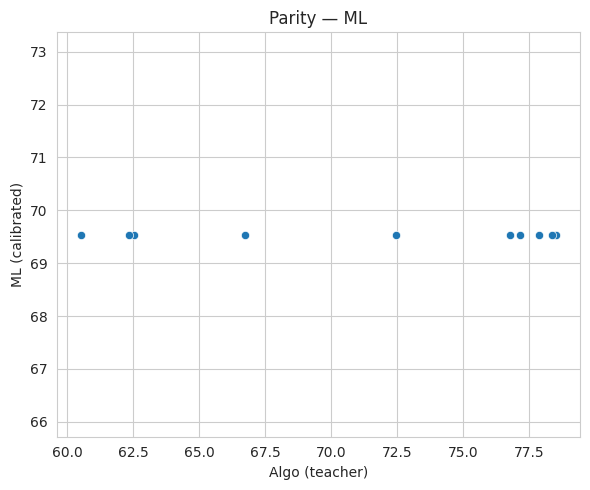

Calibrated MAE: 6.99


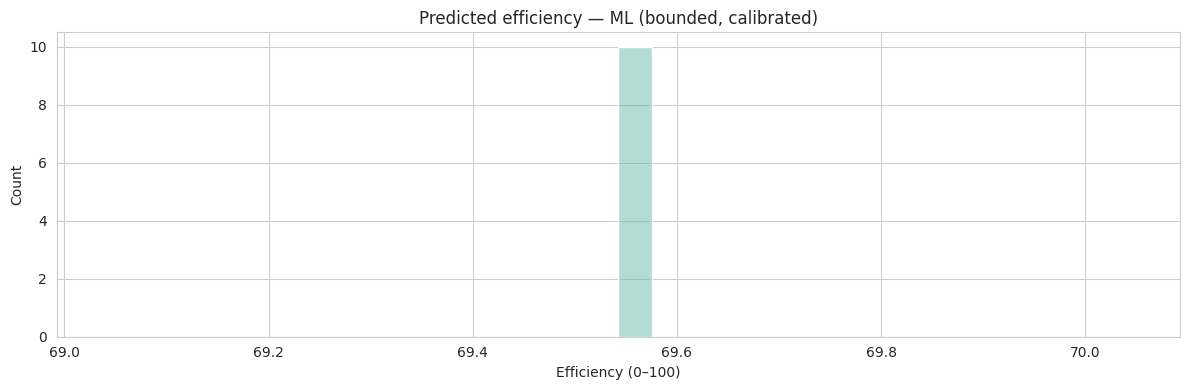

In [ ]:
# === Cell 6 - monotonic GBM + isotonic calibration (learned once) ===
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

# 1) Build ML features (length-invariant) & target from algorithm
def agg_for_ml(g):
    dt = g["timestamp"].diff().dt.total_seconds().fillna(0).clip(lower=0, upper=10*base_sec)
    T = float(dt.sum()); mins = max(1e-6, T/60)
    def q(s,p): return float(np.nanquantile(s, p))
    thr_a, thr_j = thr_accel, thr_jerk
    sharp = ((g["ACCEL"].abs()>thr_a) | (g["JERK"].abs()>thr_j)).values
    fr = len(np.flatnonzero(np.diff(np.r_[False, sharp, False])))//2 / mins

    feats = {
        "duration_min":  mins,
        "distance_km":   g["dist_m"].sum()/1000.0,
        "speed_mean":    float(g["SPEED_ms"].mean()),
        "speed_q90":     q(g["SPEED_ms"],0.90),
        "accel_q90":     q(g["ACCEL"].abs(),0.90),
        "jerk_q90":      q(g["JERK"].abs(),0.90),
        "sharp_freq_pm": fr,
        "idle_frac":     float(g["IDLE_RULE"].mean()),
        "idle_epm":      len(np.flatnonzero(np.diff(np.r_[False, g["IDLE_RULE"].values, False])))//2 / mins,
        "rpm_q90":       q(g["RPM"],0.90) if "RPM" in g else 0.0,
        "load_q85":      q(g["ENGINE_LOAD"],0.85) if "ENGINE_LOAD" in g else 0.0,
        "thr_q85":       q(g["THROTTLE_POS"],0.85) if "THROTTLE_POS" in g else 0.0,
        "maf_q90":       q(g["MAF"],0.90) if "MAF" in g else 0.0,
        # strong weights. (MAF/RPM))
        "frac_rpm90": float((g["RPM"] >= thr_rpm90).mean()) if "RPM" in g and not np.isnan(thr_rpm90) else 0.0,
        "frac_maf90": float((g["MAF"] >= thr_maf90).mean()) if "MAF" in g and not np.isnan(thr_maf90) else 0.0,
        # (optional but useful) a simple fuel-intensity proxy that remains monotonic:
        "fuel_intensity": (np.nan_to_num(g["maf_q90"]) * np.nan_to_num(g["rpm_q90"]))
                          if {"maf_q90","rpm_q90"}.issubset(g.columns) else 0.0,
            }
    return feats

rows, y = [], []
groups = []
for gid in per_drive.index:
    g = df[df["drive_id"]==gid]
    if len(g) < 5: continue
    rows.append(agg_for_ml(g))
    y.append(per_drive.loc[gid, "efficiency_algo"])
    groups.append(g["source_file"].iloc[0])

X = pd.DataFrame(rows)
y = np.array(y); groups = np.array(groups)

# Standardize non-length features; keep scalers for inference
num_cols = [c for c in X.columns if c not in ["duration_min","distance_km"]]
sc_ml = StandardScaler().fit(X[num_cols])
X[num_cols] = sc_ml.transform(X[num_cols])

# 2) Monotonic constraints: features that should LOWER efficiency as they increase ⇒ -1, neutral ⇒ 0
mono_features = ["accel_q90","jerk_q90","sharp_freq_pm","idle_frac","idle_epm","rpm_q90","load_q85","thr_q85","maf_q90", "frac_rpm90","frac_maf90", "fuel_intensity"]
mono = []
for col in X.columns:
    mono.append(-1 if col in mono_features else 0)

# 3) Grouped CV (by file) for calibration; fit on train, calibrate on val once
gkf = GroupKFold(n_splits=min(5, len(np.unique(groups))))
train_idx, val_idx = next(gkf.split(X, y, groups=groups))  # first split is fine for a single calibrator

Xtr, Xval = X.iloc[train_idx], X.iloc[val_idx]
ytr, yval = y[train_idx], y[val_idx]
wtr = np.clip(Xtr["duration_min"].values, 0.5, None) * (
      1.0 + 0.30*np.nan_to_num(Xtr.get("frac_maf90", 0.0)) +
      0.20*np.nan_to_num(Xtr.get("frac_rpm90", 0.0)))  # weight longer drives a bit more

gbm = HistGradientBoostingRegressor(
    loss="squared_error",
    max_depth=10, # increase if show underfit
    learning_rate=0.07,
    max_bins=255,
    early_stopping=True,
    monotonic_cst=mono,
    random_state=42
)
gbm.fit(Xtr, ytr, sample_weight=wtr)

# 4) One-time isotonic calibration learned from validation predictions (not per batch)
raw_val = gbm.predict(Xval)
iso_cal = IsotonicRegression(out_of_bounds="clip").fit(raw_val, yval)

# 5) Fit final model on all data (same hyperparams), keep calibrator & scaler
w_all = np.clip(X["duration_min"].values, 0.5, None) * (
        1.0 + 0.30*np.nan_to_num(X.get("frac_maf90", 0.0)) +
        0.20*np.nan_to_num(X.get("frac_rpm90", 0.0))
)
# Diagnostics: train-val parity & distribution
raw_all = gbm.predict(X)
pred_all = iso_cal.predict(raw_all)
plt.figure(figsize=(6,5))
sns.scatterplot(x=y, y=pred_all, s=35)
plt.xlabel("Algo (teacher)"); plt.ylabel("ML (calibrated)")
plt.title("Parity — ML"); plt.grid(True); plt.tight_layout(); plt.show()
print("Calibrated MAE:", np.mean(np.abs(y - pred_all)).round(2))

plt.figure(figsize=(12,4))
sns.histplot(pred_all, bins=30, kde=True, color="#6BBBAE")
plt.title("Predicted efficiency — ML (bounded, calibrated)"); plt.xlabel("Efficiency (0–100)")
plt.tight_layout(); plt.show()

# 6) Inference function (length-invariant; reuses sc_ml, gbm, iso_cal)
def predict_efficiency_ml(df_new: pd.DataFrame) -> float:
    d = df_new.copy()
    d["timestamp"] = ensure_dt(d["timestamp"])
    d = safe_num(d, [c for c in CORE_COLS if c!="timestamp"]).dropna(subset=["timestamp"]).sort_values("timestamp")
    if len(d)<5: return float("nan")
    base = infer_base_interval_seconds(d["timestamp"])
    d["SPEED_ms"] = d["SPEED"]*KMH_TO_MS
    d["ACCEL"] = d["SPEED_ms"].diff()/max(base,1e-3)
    d["JERK"]  = d["ACCEL"].diff()/max(base,1e-3)
    # rule idle (same as earlier)
    speed_low = (d["SPEED_ms"].abs() <= 0.6)
    thr_low   = (d["THROTTLE_POS"] <= df["THROTTLE_POS"].quantile(0.10)) if "THROTTLE_POS" in df else True
    load_low  = (d["ENGINE_LOAD"]  <= df["ENGINE_LOAD"].quantile(0.15))  if "ENGINE_LOAD" in df else True
    maf_low   = (d["MAF"]          <= df["MAF"].quantile(0.10))          if "MAF" in df else True
    accel_low = (d["ACCEL"].abs()  <= df["ACCEL"].abs().quantile(0.20))
    from scipy.signal import medfilt as _med
    d["IDLE_RULE"] = _med((speed_low & thr_low & load_low & maf_low & accel_low).astype(int), 5).astype(bool)

    # Minimal windows for features used by agg_for_ml()
    W10 = rows_for(10, base)
    for col in ["SPEED_ms"]:
        d[f"{col}_mean_w10"] = d[col].rolling(W10,1).mean()
        d[f"{col}_std_w10"]  = d[col].rolling(W10,1).std()
    d["dist_m"] = d["SPEED_ms"] * d["timestamp"].diff().dt.total_seconds().fillna(0).clip(lower=0, upper=10*base)

    feats = agg_for_ml(d)
    x = pd.DataFrame([feats], columns=X.columns)
    x[num_cols] = sc_ml.transform(x[num_cols])  # reuse training scaler
    y_raw = gbm.predict(x)
    return float(np.clip(iso_cal.predict(y_raw)[0], 0, 100))


# Chunking test

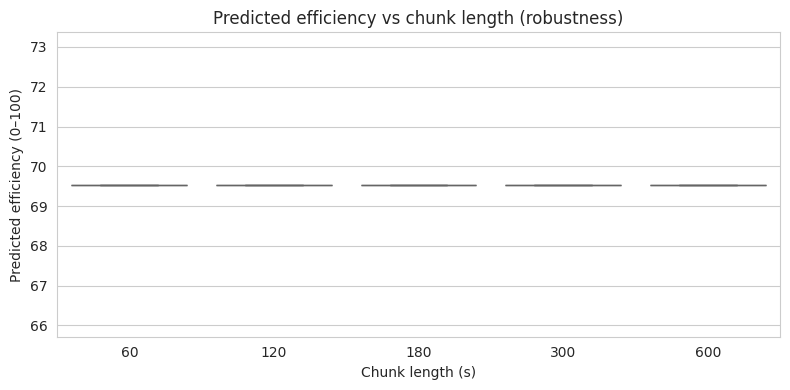

Std dev of predictions by chunk length:
 chunk_sec
60     0.0
120    0.0
180    0.0
300    0.0
600    0.0
Name: pred_eff, dtype: float64


In [ ]:
# === Cell 7 — Robustness to trip length: random chunking test ===
rng = np.random.default_rng(42)
rows = []
for gid in ranked.index[: min(50, len(ranked))]:  # test on up to 50 drives
    g = df[df["drive_id"]==gid].copy()
    if len(g) < 120: continue
    n = len(g)
    for L in [60,120,180,300,600]:  # chunk lengths in seconds
        step = max(1, int(round(L/max(base_sec,1e-3))))
        for _ in range(4):
            start = rng.integers(0, max(1, n-step))
            chunk = g.iloc[start:start+step].copy()
            try:
                eff = predict_efficiency_ml(chunk[CORE_COLS])
            except KeyError as e:
                print(f"⚠️ Missing {e} in gid={gid}, L={L}, skipping")
                eff = np.nan
            rows.append({"drive_id":gid, "chunk_sec":L, "pred_eff":eff})

rob = pd.DataFrame(rows).dropna()
plt.figure(figsize=(8,4))
sns.boxplot(x="chunk_sec", y="pred_eff", data=rob, color="#9CCB86")
plt.title("Predicted efficiency vs chunk length (robustness)")
plt.xlabel("Chunk length (s)"); plt.ylabel("Predicted efficiency (0–100)")
plt.tight_layout(); plt.show()

sd_by_len = rob.groupby("chunk_sec")["pred_eff"].std()
print("Std dev of predictions by chunk length:\n", sd_by_len.round(2))


# Dashboards

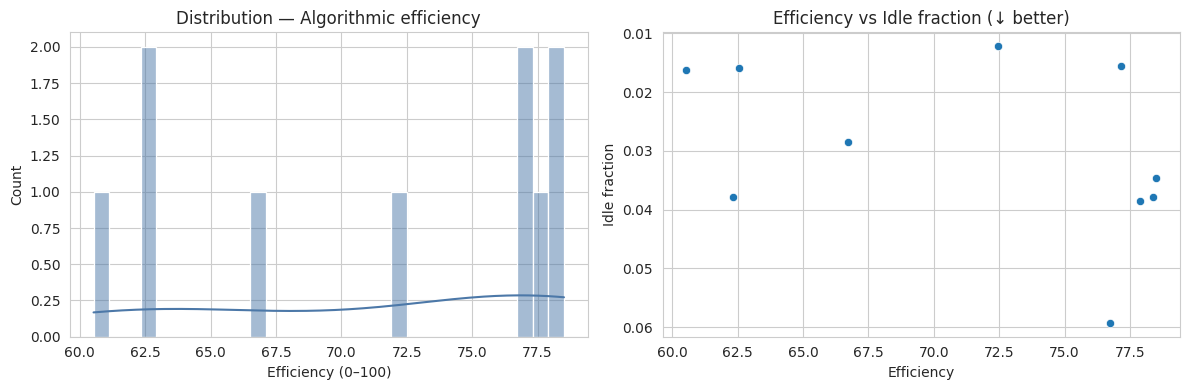

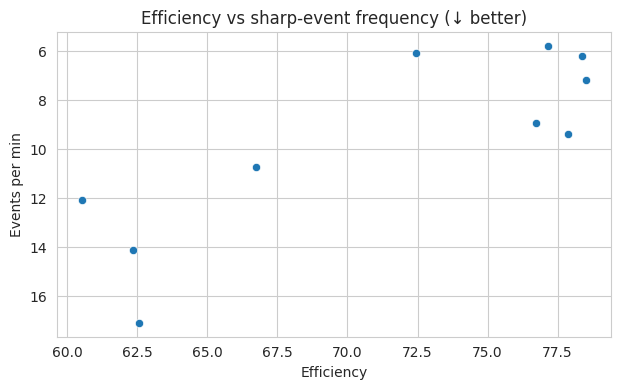

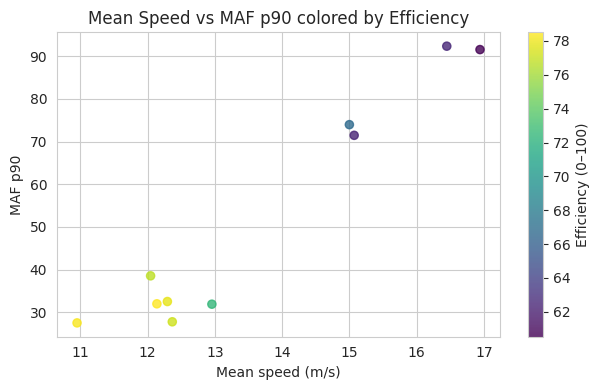

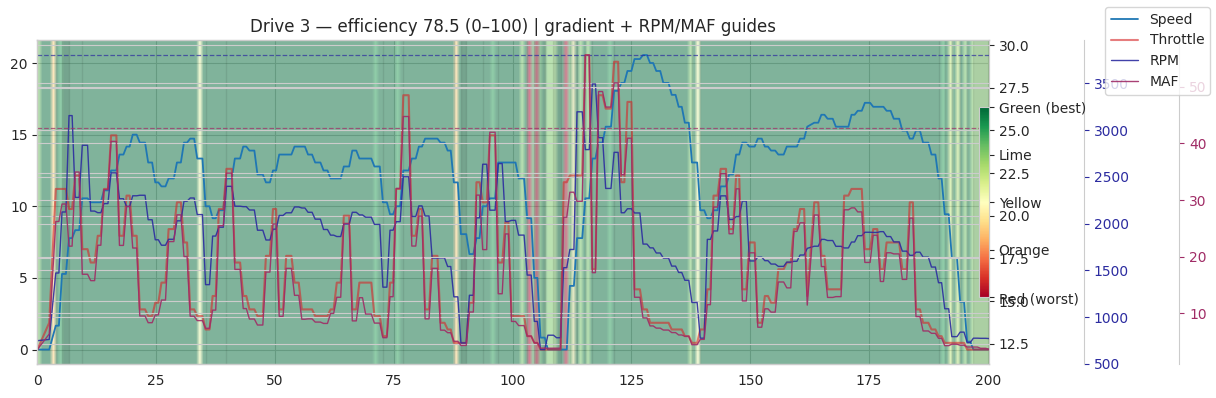

,peak_over_thr,dur_s
count,24.000000,24.000000
mean,1.680555,0.866667
std,0.413879,0.530723
min,1.000000,0.650000
25%,1.458333,0.650000
50%,1.666666,0.650000
75%,1.874999,0.650000
max,2.666666,2.600000


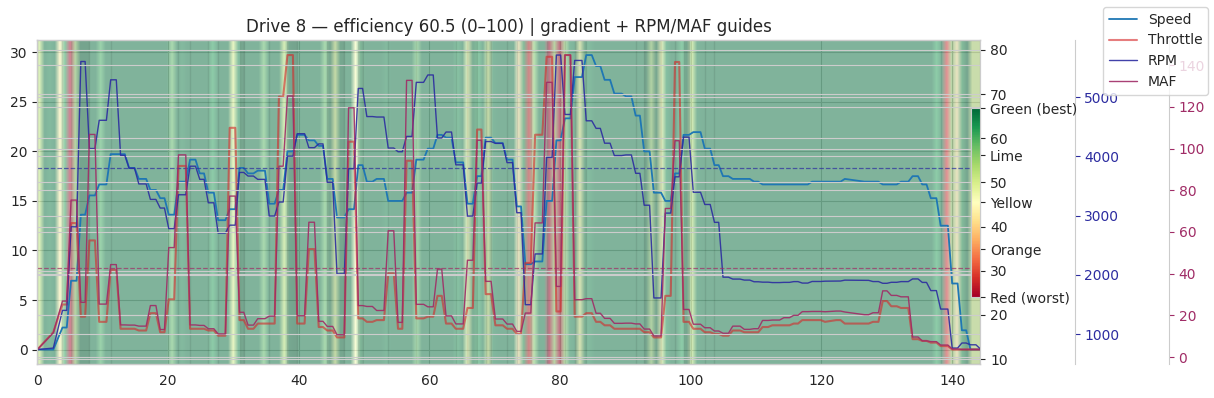

,peak_over_thr,dur_s
count,29.000000,29.000000
mean,2.080459,1.344828
std,0.830496,0.934397
min,1.000000,0.650000
25%,1.333333,0.650000
50%,1.999999,0.650000
75%,2.499999,1.950000
max,3.999998,3.250000


In [ ]:
# === Cell 8.1 — Sanity dashboards ===
# Safe fleet thresholds (fallback to fleet quantiles if 'thr' dict isn't defined)
rpm90_thr = None
maf90_thr = None

if "RPM" in df.columns:
    try:
        rpm90_thr = float(thr["RPM90"])
    except Exception:
        rpm90_thr = float(np.nanquantile(df["RPM"], 0.90)) if df["RPM"].notna().any() else np.nan

if "MAF" in df.columns:
    try:
        maf90_thr = float(thr["MAF90"])
    except Exception:
        maf90_thr = float(np.nanquantile(df["MAF"], 0.90)) if df["MAF"].notna().any() else np.nan

# Per-drive exposure (fraction of time ≥ 90th percentile), aligned to dfeat.index
dfeat = dfeat.copy()

if "RPM" in df.columns and rpm90_thr is not None and not np.isnan(rpm90_thr):
    exp_rpm = df.groupby("drive_id")["RPM"].apply(lambda s: (s >= rpm90_thr).mean())
    dfeat["frac_rpm90"] = exp_rpm.reindex(dfeat.index).fillna(0.0).astype(float)
else:
    dfeat["frac_rpm90"] = 0.0

if "MAF" in df.columns and maf90_thr is not None and not np.isnan(maf90_thr):
    exp_maf = df.groupby("drive_id")["MAF"].apply(lambda s: (s >= maf90_thr).mean())
    dfeat["frac_maf90"] = exp_maf.reindex(dfeat.index).fillna(0.0).astype(float)
else:
    dfeat["frac_maf90"] = 0.0

# Distribution: algorithmic efficiency
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(dfeat["efficiency_algo"], bins=30, kde=True, color="#4C78A8")
plt.title("Distribution — Algorithmic efficiency"); plt.xlabel("Efficiency (0–100)")

# Efficiency vs Idle (↓ better)
plt.subplot(1,2,2)
sns.scatterplot(x=dfeat["efficiency_algo"], y=dfeat["idle_frac"], s=35)
plt.gca().invert_yaxis()
plt.title("Efficiency vs Idle fraction (↓ better)"); plt.xlabel("Efficiency"); plt.ylabel("Idle fraction")
plt.tight_layout(); plt.show()

# Efficiency vs sharp-event frequency (↓ better)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.scatterplot(x=dfeat["efficiency_algo"], y=dfeat["freq_pm"], s=35)
plt.gca().invert_yaxis()
plt.title("Efficiency vs sharp-event frequency (↓ better)"); plt.xlabel("Efficiency"); plt.ylabel("Events per min")
plt.tight_layout(); plt.show()

# # Scatter: Efficiency vs MAF90 exposure (expected ↓ trend)
# if "frac_maf90" in dfeat.columns:
#     plt.figure(figsize=(6,5))
#     sns.scatterplot(x=dfeat["efficiency_algo"], y=dfeat["frac_maf90"], s=35)
#     plt.gca().invert_yaxis()
#     plt.title("Efficiency vs MAF90 exposure (↓ better)")
#     plt.xlabel("Efficiency (0–100)"); plt.ylabel("Frac time ≥ MAF90")
#     plt.tight_layout(); plt.show()

# # Scatter: Efficiency vs RPM90 exposure (expected ↓ trend)
# if "frac_rpm90" in dfeat.columns:
#     plt.figure(figsize=(6,5))
#     sns.scatterplot(x=dfeat["efficiency_algo"], y=dfeat["frac_rpm90"], s=35)
#     plt.gca().invert_yaxis()
#     plt.title("Efficiency vs RPM90 exposure (↓ better)")
#     plt.xlabel("Efficiency (0–100)"); plt.ylabel("Frac time ≥ RPM90")
#     plt.tight_layout(); plt.show()

# Per-drive p90/means for 2D view (guard missing cols)
aggs = {}
if "SPEED_ms" in df.columns:
    aggs["speed_mean"] = ("SPEED_ms","mean")
if "MAF" in df.columns:
    aggs["maf_p90"]   = ("MAF", lambda s: np.nanquantile(s, 0.90) if s.notna().any() else np.nan)
if "RPM" in df.columns:
    aggs["rpm_p90"]   = ("RPM", lambda s: np.nanquantile(s, 0.90) if s.notna().any() else np.nan)

if aggs:
    per_drive_stats = df.groupby("drive_id").agg(**aggs).join(dfeat[["efficiency_algo"]], how="left")
    if {"speed_mean","maf_p90"}.issubset(per_drive_stats.columns):
        plt.subplot(1,2,2)
        sc = plt.scatter(per_drive_stats["speed_mean"], per_drive_stats["maf_p90"],
                         c=per_drive_stats["efficiency_algo"], s=35, alpha=0.8, cmap="viridis")
        plt.colorbar(sc, label="Efficiency (0–100)")
        plt.title("Mean Speed vs MAF p90 colored by Efficiency")
        plt.xlabel("Mean speed (m/s)"); plt.ylabel("MAF p90")
        plt.tight_layout(); plt.show()


# === Cell 8.2 — Per-drive timeline diagnostics & scoring ===
def plot_drive_timeline(drive_id, df, thr_accel, thr_jerk):
    """Plot one drive with gradient effectiveness shading + RPM/MAF guides + sharp episode stats."""
    g = df[df["drive_id"]==drive_id].copy()
    if g.empty:
        return

    # time relative to start
    t = (g["timestamp"] - g["timestamp"].iloc[0]).dt.total_seconds()

    # inefficiency zones = sharp accel/jerk + idle
    g_sharp = (g["ACCEL"].abs()>thr_accel) | (g["JERK"].abs()>thr_jerk)
    ineff_zone = g_sharp | g["IDLE_RULE"]

    # ---------- effectiveness gradient (same logic as Cell 5) ----------
    A = g["ACCEL"].abs().fillna(0)
    J = g["JERK"].abs().fillna(0)
    a_hi = np.nanpercentile(A, 98) if A.notna().any() else 1.0
    j_hi = np.nanpercentile(J, 98) if J.notna().any() else 1.0

    sev_a = np.clip((A - thr_accel) / max(1e-6, a_hi - thr_accel), 0, 1)
    sev_j = np.clip((J - thr_jerk)  / max(1e-6, j_hi - thr_jerk ), 0, 1)
    idle  = g["IDLE_RULE"].astype(float)
    ineff_raw = 0.45*sev_a + 0.25*sev_j + 0.30*idle

    # Contrast calibration (focus on actual inefficient region if present)
    focus = ineff_raw.where(ineff_zone, np.nan).dropna()
    if len(focus) > 0:
        q_lo, q_hi = np.nanquantile(focus, [0.15, 0.98])
    else:
        q_lo, q_hi = np.nanquantile(ineff_raw, [0.15, 0.98])
    span = max(1e-6, q_hi - q_lo)
    ineff01 = np.clip((ineff_raw - q_lo) / span, 0, 1)
    GAMMA = 0.8  # <1 → more contrast near the extremes
    effectiveness = (1.0 - ineff01) ** GAMMA  # 1=green (best), 0=red (worst)
    # -------------------------------------------------------------------

    import matplotlib as mpl
    fig, ax1 = plt.subplots(figsize=(12,4))
    l1 = ax1.plot(t, g["SPEED_ms"], label="Speed", linewidth=1.3, zorder=3)[0]
    ax2 = ax1.twinx()
    # Throttle might be missing in some datasets; guard it
    if "THROTTLE_POS" in g.columns:
        l2 = ax2.plot(t, g["THROTTLE_POS"], color="#D62728", alpha=0.6, label="Throttle", zorder=3)[0]
        lines = [l1, l2]
    else:
        lines = [l1]

    # Helper to create offset right axes for extra series
    def _make_twin(ax, offset):
        ax_new = ax.twinx()
        ax_new.spines["right"].set_position(("axes", offset))
        ax_new.spines["right"].set_visible(True)
        return ax_new

    # Fleet thresholds (fallback to fleet quantiles)
    rpm90_thr = None
    maf90_thr = None
    if "RPM" in df.columns:
        try:
            rpm90_thr = float(thr["RPM90"])
        except Exception:
            rpm90_thr = float(np.nanquantile(df["RPM"], 0.90)) if df["RPM"].notna().any() else np.nan
    if "MAF" in df.columns:
        try:
            maf90_thr = float(thr["MAF90"])
        except Exception:
            maf90_thr = float(np.nanquantile(df["MAF"], 0.90)) if df["MAF"].notna().any() else np.nan

    # Extra axes for RPM/MAF (right side offsets)
    ax_rpm = _make_twin(ax1, 1.10)
    ax_maf = _make_twin(ax1, 1.20)

    if "RPM" in g.columns:
        l_rpm = ax_rpm.plot(t, g["RPM"], color="#2c2ca0", linewidth=1.0, alpha=0.9, label="RPM")[0]
        if rpm90_thr is not None and not np.isnan(rpm90_thr):
            ax_rpm.axhline(rpm90_thr, color="#2c2ca0", linestyle="--", linewidth=0.9, alpha=0.7)
        ax_rpm.tick_params(axis='y', colors="#2c2ca0")
        lines.append(l_rpm)

    if "MAF" in g.columns:
        l_maf = ax_maf.plot(t, g["MAF"], color="#a02c66", linewidth=1.0, alpha=0.9, label="MAF")[0]
        if maf90_thr is not None and not np.isnan(maf90_thr):
            ax_maf.axhline(maf90_thr, color="#a02c66", linestyle="--", linewidth=0.9, alpha=0.7)
        ax_maf.tick_params(axis='y', colors="#a02c66")
        lines.append(l_maf)

    # Effectiveness background & inefficient zone shading
    ymin, ymax = ax1.get_ylim()
    grad = np.tile(effectiveness.to_numpy(), (128, 1))
    ax1.imshow(
        grad, extent=[t.min(), t.max(), ymin, ymax],
        cmap="RdYlGn", aspect="auto", interpolation="bilinear",
        alpha=0.50, vmin=0, vmax=1, origin="lower", zorder=1
    )
    ax1.fill_between(t, ymin, ymax, where=ineff_zone.values,
                     color="black", alpha=0.08, step="pre", zorder=2)

    eff = float(dfeat.loc[drive_id, "efficiency_algo"])
    ax1.set_title(f"Drive {drive_id} — efficiency {eff:.1f} (0–100) | gradient + RPM/MAF guides")
    # ax1.set_xlabel("Time (s)")
    # ax1.set_ylabel("Speed (m/s)")
    # ax2.set_ylabel("Throttle (%)")

    labels = [ln.get_label() for ln in lines]
    fig.legend(lines, labels, loc="upper right")

    # colorbar
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = mpl.cm.ScalarMappable(cmap="RdYlGn", norm=norm); sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax1, pad=0.01, fraction=0.01, aspect=20)
    # cbar.set_label("Effectiveness", labelpad=10)
    cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
    cbar.set_ticklabels(["Red (worst)", "Orange", "Yellow", "Lime", "Green (best)"])

    plt.tight_layout(); plt.show()

    # --- sharp episode stats ---
    starts, lens = run_lengths(g_sharp.values)
    peaks, kinds = [], []
    for st, ln in zip(starts, lens):
        seg = g.iloc[st:st+ln]
        pa, pj = float(seg["ACCEL"].abs().max()), float(seg["JERK"].abs().max())
        peaks.append(max(pa/(thr_accel+1e-6), pj/(thr_jerk+1e-6)))
        kinds.append("accel" if pa>=pj else "jerk")
    ep_df = pd.DataFrame({"kind":kinds, "peak_over_thr":peaks,
                          "dur_s": lens*infer_base_interval_seconds(g["timestamp"])})
    display(ep_df.describe())

# Example: plot best and worst drives
best_id  = int(dfeat["efficiency_algo"].idxmax())
worst_id = int(dfeat["efficiency_algo"].idxmin())
plot_drive_timeline(best_id, df, thr_accel, thr_jerk)
plot_drive_timeline(worst_id, df, thr_accel, thr_jerk)

## Summary

### 1. **Driver Behavior Clustering (Unsupervised)**

* **Feature engineering:**

  * Derived signals include `ACCEL`, `JERK`, `AIRFLOW_PER_RPM`, and `THROTTLE_D`.
  * Rolling mean/std features across 1–8 second windows to capture local driving dynamics.
* **Event-rate features:** Based on quantile thresholds to count high acceleration, braking, and throttle bursts.
* **Idle detection (Stage-1):**

  * **Rule-based method:** conservative thresholds on speed, throttle, RPM variance, and accel variance, smoothed with median filters.
  * **ML-based method:** Bayesian Gaussian Mixture (BGMM) separating true idle vs creeping.
  * Both compared for reliability and interpretability.
* **Stage-2 clustering:**

  * Non-idle segments clustered into **Passive, Moderate, Aggressive** using Bayesian GMM on PCA-reduced dynamics features.
  * **Aggressiveness score:** constructed from weighted features (jerk, accel bursts, throttle variability, etc.).
* **Validation tools:**

  * PCA projection plots (GT vs unsupervised labels).
  * Radar charts for cluster profiles.
  * Cluster fraction reports, overlap statistics (Mahalanobis), and silhouette scores.

---

### 2. **Idle State Comparison**

* **Two complementary definitions:**

  * **Rule-based:** interpretable thresholds for practical validation.
  * **ML-based:** probabilistic BGMM for finer separation of creeping vs idle.
* **Comparative statistics:** Idle fractions, duration distributions, overlap with ground truth, and visual temporal traces.

---

### 3. **Fuel Efficiency Scoring (Hybrid Approach)**

* **Scoring design:** Efficiency bounded between 0–100%, driven by:

  * **Magnitude:** penalizes *sharp* acceleration/deceleration only when beyond data-driven quantile thresholds.
  * **Frequency:** counts of sharp events normalized per km or per minute.
  * **Duration:** weight for long-lasting inefficient segments (sustained jerky driving).
  * **Idle penalty:** proportion of time spent idling relative to trip duration.
* **Composite efficiency index:** smooth, bounded function combining the above via learned weights; avoids artificial 0%/100% extremes.
* **Visual outputs:**

  * Histograms and per-trip bars of efficiency scores.
  * Time series overlays showing efficiency drops during bursts or prolonged idling.

---

### 4. **Towards Predictive ML/DL**

* **Length-invariant training strategy:**

  * Each drive session represented by summary features (e.g., idle fraction, sharp-event rate/km, p95 RPM, throttle variability).
  * Allows consistent training across trips of varying durations.
* **Model candidates:**

  * **Tree-based learners:** Random Forest, Gradient Boosting (LightGBM/XGBoost) with monotonic constraints.
  * **Sequence models:** LSTM/Temporal CNNs to capture raw OBD-II time-series patterns.
* **Calibration & evaluation:**

  * Compare predicted vs algorithmic efficiency scores.
  * Calibrate against actual fuel consumption data when available.
  * Assess both accuracy and interpretability to balance client needs.

# Export

## Train

In [ ]:
# === Cell 9 — Train & Export Reproducible Efficiency Model ===
# Key changes:
#  • Cross-fitted (OOF) isotonic calibration (no leakage), sign decided on OOF
#  • Remove collinear RPM/MAF quantiles; keep exposure fractions (≥p90)
#  • Monotonic only on defensible "bad" factors
#  • Robust loss + L2 regularization
#  • Small seed-ensemble to reduce variance with tiny N
import os, json, sys, math, joblib, numpy as np, pandas as pd
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

SEED = 42
np.random.seed(SEED)

# ----- Build training table X,y,groups (uses your existing agg_for_ml, thr, df, dfeat) -----
rows, y, groups = [], [], []
for gid in dfeat.index:
    g = df[df["drive_id"] == gid]
    if g.empty:
        continue
    g = g.copy()
    g["timestamp"] = ensure_dt(g["timestamp"])
    g = g.dropna(subset=["timestamp"]).sort_values("timestamp")
    if len(g) < 5:
        continue
    if not {"SPEED_ms","ACCEL","JERK"}.issubset(g.columns):
        g = add_basic_derivatives(g)
    feats = agg_for_ml(g, thr)
    rows.append(feats)
    y.append(float(dfeat.loc[gid, "efficiency_algo"]))
    groups.append(g["source_file"].iloc[0] if "source_file" in g.columns else gid)

X = pd.DataFrame(rows); y = np.asarray(y, float); groups = np.asarray(groups)

# --- Smoother: Univariate, rank-based feature screening (tiny-N safe) ---
# Keep only features with |Spearman| >= 0.15 vs teacher; drop the rest.
feat_spear = {}
for c in X.columns:
    try:
        feat_spear[c] = abs(pd.Series(X[c]).corr(pd.Series(y), method="spearman"))
    except Exception:
        feat_spear[c] = 0.0

# Never drop these context cols, even if low signal:
must_keep = {"duration_min","distance_km"}
keep_cols = {c for c,a in feat_spear.items() if a >= 0.15} | must_keep
drop_cols = [c for c in X.columns if c not in keep_cols]
if drop_cols:
    X = X.drop(columns=drop_cols)

# ----- Reduce collinearity (keep RPM/MAF exposures; drop raw p-quantiles & product) -----
for c in ["rpm_q90","maf_q90","fuel_intensity"]:
    if c in X.columns: X.drop(columns=c, inplace=True, errors="ignore")

# Feature sets
holdout_cols = ["duration_min","distance_km"]              # not scaled (absolute trip context)
num_cols = [c for c in X.columns if c not in holdout_cols]

# Monotonic constraints: only defensible "bad" drivers
mono_neg = {
    "accel_q90","jerk_q90","sharp_freq_pm","idle_frac","idle_epm",
    "frac_rpm90","frac_maf90"  # exposures are stronger than raw quantiles
}
mono = [-1 if c in mono_neg else 0 for c in X.columns]

# ----- Cross-fitted OOF isotonic (no leakage): scaler+model refit per fold -----
def oof_iso_calibration(X, y, groups, num_cols, mono, seeds=(42,1337,7), n_splits=5):
    gkf = GroupKFold(n_splits=min(n_splits, max(2, len(np.unique(groups)))))
    oof_raw = np.zeros_like(y, dtype=float)

    for tr, va in gkf.split(X, y, groups=groups):
        Xtr, Xva = X.iloc[tr].copy(), X.iloc[va].copy()
        ytr = y[tr]

        sc = StandardScaler().fit(Xtr[num_cols])             # scale INSIDE fold
        Xtr[num_cols] = sc.transform(Xtr[num_cols])
        Xva[num_cols] = sc.transform(Xva[num_cols])

        # small seed-ensemble; average raw
        preds = []
        base_params = dict(
            loss="absolute_error",       # more robust to small N/outliers
            max_depth=5,
            learning_rate=0.06,
            l2_regularization=1.0,       # mild shrinkage
            max_bins=255,
            early_stopping=True,
            monotonic_cst=mono
        )
        for s in seeds:
            mdl = HistGradientBoostingRegressor(random_state=s, **base_params).fit(Xtr, ytr)
            preds.append(mdl.predict(Xva))
        oof_raw[va] = np.mean(preds, axis=0)

    # orientation from OOF (global, not one fold)
    pear = np.corrcoef(oof_raw, y)[0,1]
    invert = bool(pear < 0)
    x_for_iso = -oof_raw if invert else oof_raw
    iso = IsotonicRegression(out_of_bounds="clip").fit(x_for_iso, y)

    # report OOF sanity
    mae = mean_absolute_error(y, iso.predict(x_for_iso))
    r2  = r2_score(y, iso.predict(x_for_iso))
    return iso, invert, dict(oof_mae=mae, oof_r2=r2, oof_pear=pear)

##### --- global orientation & calibration on ALL data (post-ensemble) ---
Xs = X.copy()
Xs[[c for c in Xs.columns if c not in {"duration_min","distance_km"}]] = sc_ml.transform(
    Xs[[c for c in Xs.columns if c not in {"duration_min","distance_km"}]]
)
raw_all = np.mean([m.predict(Xs) for m in gbm_list], axis=0)
# Spearman calibration
pear_all   = np.corrcoef(raw_all, y)[0,1]
spear_all  = pd.Series(raw_all).corr(pd.Series(y), method="spearman")
# Decide orientation using BOTH signals (robust on tiny N)
calib_invert_final = bool((pear_all < 0) or (spear_all < 0))
# ISO
x_for_iso_final = (-raw_all) if calib_invert_final else raw_all
iso_final = IsotonicRegression(out_of_bounds="clip").fit(x_for_iso_final, y)
print(f"[Final orientation] pear={pear_all:.3f}, spear={spear_all:.3f} → invert={calib_invert_final}")
##### Treat this as a different unit

iso_cal, calib_invert, oof_stats = oof_iso_calibration(X, y, groups, num_cols, mono)

# ----- Final scaler on ALL data (for inference) -----
sc_ml = StandardScaler().fit(X[num_cols])
Xs = X.copy(); Xs[num_cols] = sc_ml.transform(Xs[num_cols])

# ----- Train final seed-ensemble on ALL data (uses same params) -----
base_params_final = dict(
    loss="absolute_error", # Can use huber for smoother val but lower acc
    max_depth=5,
    learning_rate=0.06,
    l2_regularization=1.0,
    max_bins=255,
    early_stopping=True,
    monotonic_cst=mono
)
seeds_final = (42,1337,7,19,23)
gbm_list = []
# gentle weights: longer + higher demand exposures
w_all = np.clip(Xs["duration_min"].values, 0.5, None) * (
    1.0 + 0.30*np.nan_to_num(Xs.get("frac_maf90", 0.0)) +
    0.20*np.nan_to_num(Xs.get("frac_rpm90", 0.0))
)
for s in seeds_final:
    mdl = HistGradientBoostingRegressor(random_state=s, **base_params_final).fit(Xs, y, sample_weight=w_all)
    gbm_list.append(mdl)

# ----- Export artifacts -----
EXPORT_DIR = "./efficiency_export"; os.makedirs(EXPORT_DIR, exist_ok=True)
artifacts = {
    "scaler": sc_ml,
    "gbm_list": gbm_list,
    # "iso": iso_cal,                # Pre-calibration
    # "calib_invert": calib_invert,
    "iso": iso_final,
    "calib_invert": calib_invert_final,
    "feature_names": list(X.columns),
    "num_cols": num_cols,
    "holdout_cols": holdout_cols,
    "mono_neg": list(mono_neg),
    "windowing": {"size_s": 120, "step_s": 60},
    "thr": thr,
    "seeds": list(seeds_final),
    "oof_stats": oof_stats,
    "seed": SEED
}
joblib.dump(artifacts, os.path.join(EXPORT_DIR, "efficiency_model.joblib"))

with open(os.path.join(EXPORT_DIR, "efficiency_meta.json"), "w") as f:
    json.dump({"schema": artifacts["feature_names"], "oof_stats": oof_stats}, f, indent=2)

print("✅ Exported model with OOF isotonic. OOF stats:", oof_stats)

# ----- Inference helpers (ensemble-aware, orientation-aware) -----
def _load_artifacts(path="./efficiency_export/efficiency_model.joblib"):
    return joblib.load(path)

def _to_dataframe(log_like):
    if isinstance(log_like, pd.DataFrame):
        return log_like.copy()
    if isinstance(log_like, str):
        return pd.read_csv(log_like)
    raise TypeError("Input must be a DataFrame or CSV file path.")

def _predict_efficiency_df(d: pd.DataFrame, art) -> float:
    d = d.copy()
    if "timestamp" not in d.columns:
        raise ValueError("Log must include 'timestamp'.")
    if "SPEED" not in d.columns:
        d["SPEED"] = np.nan

    d["timestamp"] = ensure_dt(d["timestamp"])
    d = d.dropna(subset=["timestamp"]).sort_values("timestamp")
    if d.empty: return float("nan")

    d = add_basic_derivatives(d)  # adds SPEED_ms, ACCEL, JERK, dist_m

    # windows
    size_s = art["windowing"]["size_s"]; step_s = art["windowing"]["step_s"]
    wins = list(window_iter_by_seconds(d, size_s, step_s)) or [(d.index[0], d.index[-1])]
    xs, ws = [], []
    for i0, i1 in wins:
        w = d.loc[i0:i1]
        if len(w) < 5: continue
        feats = agg_for_ml(w, art["thr"])
        x = pd.DataFrame([feats], columns=art["feature_names"])
        for col in art["feature_names"]:
            if col not in x.columns: x[col] = 0.0
        x = x[art["feature_names"]]
        x.loc[:, art["num_cols"]] = art["scaler"].transform(x[art["num_cols"]])

        # ensemble mean raw
        raw = np.mean([m.predict(x)[0] for m in art["gbm_list"]])
        if art.get("calib_invert", False): raw = -raw
        pred = float(np.clip(art["iso"].predict([raw])[0], 0, 100))
        xs.append(pred); ws.append(float(pd.to_numeric(w.get("dist_m"), errors="coerce").fillna(0).sum()))

    if not xs: return float("nan")
    xs, ws = np.array(xs,float), np.array(ws,float)
    return float(np.dot(xs, ws)/ws.sum()) if ws.sum() > 0 else float(xs.mean())

def score_log_file(log_like, model_path="./efficiency_export/efficiency_model.joblib") -> float:
    art = _load_artifacts(model_path)
    df_in = _to_dataframe(log_like)
    if "drive_id" in df_in.columns and df_in["drive_id"].nunique() > 1:
        scores, dists = [], []
        for gid, g in df_in.groupby("drive_id", sort=True):
            s = _predict_efficiency_df(g, art)
            scores.append(s)
            dists.append(float(pd.to_numeric(g.get("dist_m"), errors="coerce").fillna(0).sum()))
        scores, dists = np.array(scores,float), np.array(dists,float)
        return float(np.dot(scores, dists)/dists.sum()) if dists.sum()>0 else float(np.nanmean(scores))
    else:
        return _predict_efficiency_df(df_in, art)


print("\nUsage:")
print("  # Train & export already executed above")
print("  # Score a new CSV:\n  score = score_log_file('/path/to/new_log.csv')\n  print('Efficiency:', round(score,1))")

[Final orientation] pear=nan, spear=nan → invert=False
✅ Exported model with OOF isotonic. OOF stats: {'oof_mae': 6.4057534539710845, 'oof_r2': 0.07499329150234413, 'oof_pear': np.float64(-0.14537589120375385)}

Usage:
  # Train & export already executed above
  # Score a new CSV:
  score = score_log_file('/path/to/new_log.csv')
  print('Efficiency:', round(score,1))


## Calibrator

In [ ]:
# === Cell 10 — Orientation-aware isotonic recalibration (no retrain) — FIXED ===
# Works with artifacts exported by either the old (art["gbm"]) or new (art["gbm_list"]) pipeline.
# No model retraining: we only refit the isotonic calibrator + update "calib_invert".

import joblib, numpy as np, pandas as pd
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import GroupKFold

MODEL_PATH = "./efficiency_export/efficiency_model.joblib"
art = joblib.load(MODEL_PATH)

# --------- 0) Helper to predict raw (pre-calibration) with ensemble or single model ----------
def _predict_raw(Xframe, art):
    """Return raw predictions from artifact models (mean if ensemble)."""
    if "gbm_list" in art and isinstance(art["gbm_list"], (list, tuple)) and len(art["gbm_list"]) > 0:
        preds = [m.predict(Xframe) for m in art["gbm_list"]]
        return np.mean(np.vstack(preds), axis=0)
    elif "gbm" in art:
        return art["gbm"].predict(Xframe)
    else:
        raise KeyError("No model found in artifacts: expected 'gbm_list' or 'gbm'.")

# --------- 1) Rebuild the same ML table (X, y, groups) used for calibration ----------
rows, y, groups = [], [], []
for gid in dfeat.index:
    g = df[df["drive_id"] == gid]
    if g.empty:
        continue
    g = g.copy()
    g["timestamp"] = ensure_dt(g["timestamp"])
    g = g.dropna(subset=["timestamp"]).sort_values("timestamp")
    if len(g) < 5:
        continue
    # Ensure derived features exist
    if not {"SPEED_ms","ACCEL","JERK"}.issubset(g.columns):
        g = add_basic_derivatives(g)
    feats = agg_for_ml(g, art["thr"])
    rows.append(feats)
    y.append(float(dfeat.loc[gid, "efficiency_algo"]))
    groups.append(g["source_file"].iloc[0] if "source_file" in g.columns else gid)

X = pd.DataFrame(rows)
y = np.asarray(y, float)
groups = np.asarray(groups)

# Align columns to training schema saved in artifacts
for col in art["feature_names"]:
    if col not in X.columns:
        X[col] = 0.0
X = X[art["feature_names"]]

# Apply the training scaler saved in artifacts (no leakage; we aren't re-fitting it)
num_cols = art["num_cols"]
X.loc[:, num_cols] = art["scaler"].transform(X[num_cols])

# --------- 2) Hold out a fold to fit a NEW isotonic (like before; NO retraining of GBMs) ----------
gkf = GroupKFold(n_splits=min(5, max(2, len(np.unique(groups)))))
train_idx, val_idx = next(gkf.split(X, y, groups=groups))
Xval, yval = X.iloc[val_idx], y[val_idx]

# --------- 3) Orientation check using CURRENT model(s) ----------
raw_val = _predict_raw(Xval, art)        # works for ensemble or single model
corr = np.corrcoef(raw_val, yval)[0, 1]
invert = bool(corr < 0)                  # if negative correlation → flip before isotonic
x_for_iso = (-raw_val) if invert else raw_val

# Fit new isotonic on the validation fold
iso_new = IsotonicRegression(out_of_bounds="clip").fit(x_for_iso, yval)

print(f"Isotonic orientation: {'INVERTED (-raw)' if invert else 'NORMAL (raw)'}  |  corr(raw,y)={corr:.3f}")

# --------- 4) Update artifacts and save ----------
art["iso"] = iso_new
art["calib_invert"] = invert
joblib.dump(art, MODEL_PATH)
print("✅ Updated isotonic calibrator saved into:", MODEL_PATH)

# --------- 5) Patch the inference helper here to respect invert + ensemble ----------
def _predict_efficiency_df(d: pd.DataFrame, art) -> float:
    """Score a single continuous trace by windowing; distance-weighted mean of window scores."""
    d = d.copy()
    if "timestamp" not in d.columns:
        raise ValueError("Log must include 'timestamp'.")
    if "SPEED" not in d.columns:
        d["SPEED"] = np.nan

    d["timestamp"] = ensure_dt(d["timestamp"])
    d = d.dropna(subset=["timestamp"]).sort_values("timestamp")
    if d.empty:
        return float("nan")

    d = add_basic_derivatives(d)  # adds SPEED_ms, ACCEL, JERK, dist_m

    # Windowing (same as training export)
    size_s = art["windowing"]["size_s"]
    step_s = art["windowing"]["step_s"]
    wins = list(window_iter_by_seconds(d, size_s, step_s)) or [(d.index[0], d.index[-1])]

    xs, ws = [], []
    for i0, i1 in wins:
        w = d.loc[i0:i1]
        if len(w) < 5:
            continue
        feats = agg_for_ml(w, art["thr"])
        x = pd.DataFrame([feats], columns=art["feature_names"])
        # ensure all training columns present
        for col in art["feature_names"]:
            if col not in x.columns:
                x[col] = 0.0
        x = x[art["feature_names"]]
        x.loc[:, art["num_cols"]] = art["scaler"].transform(x[art["num_cols"]])

        raw = _predict_raw(x, art)[0]
        if art.get("calib_invert", False):
            raw = -raw
        pred = float(np.clip(art["iso"].predict([raw])[0], 0, 100))
        xs.append(pred)
        ws.append(float(pd.to_numeric(w.get("dist_m"), errors="coerce").fillna(0).sum()))

    if not xs:
        return float("nan")
    xs, ws = np.array(xs, float), np.array(ws, float)
    return float(np.dot(xs, ws)/ws.sum()) if ws.sum() > 0 else float(xs.mean())


Isotonic orientation: NORMAL (raw)  |  corr(raw,y)=nan
✅ Updated isotonic calibrator saved into: ./efficiency_export/efficiency_model.joblib


## Validation


=== RAW ensemble outputs vs Teacher ===
MAE   : 7.09 | RMSE: 7.47 | R^2: -0.105
Pearson r : nan | Spearman : nan

=== Calibrated (stored orientation=False) vs Teacher ===
MAE   : 6.99 | RMSE: 7.32 | R^2: -0.063
Pearson r : nan | Spearman : nan

=== Calibrated (re-fitted; invert=True) vs Teacher ===
MAE   : 3.15 | RMSE: 4.35 | R^2: 0.625
Pearson r : 0.790 | Spearman : 0.822

✅ Replaced calibrator in ./efficiency_export/efficiency_model.joblib (invert=True). Rank correlation improved from nan → 0.822


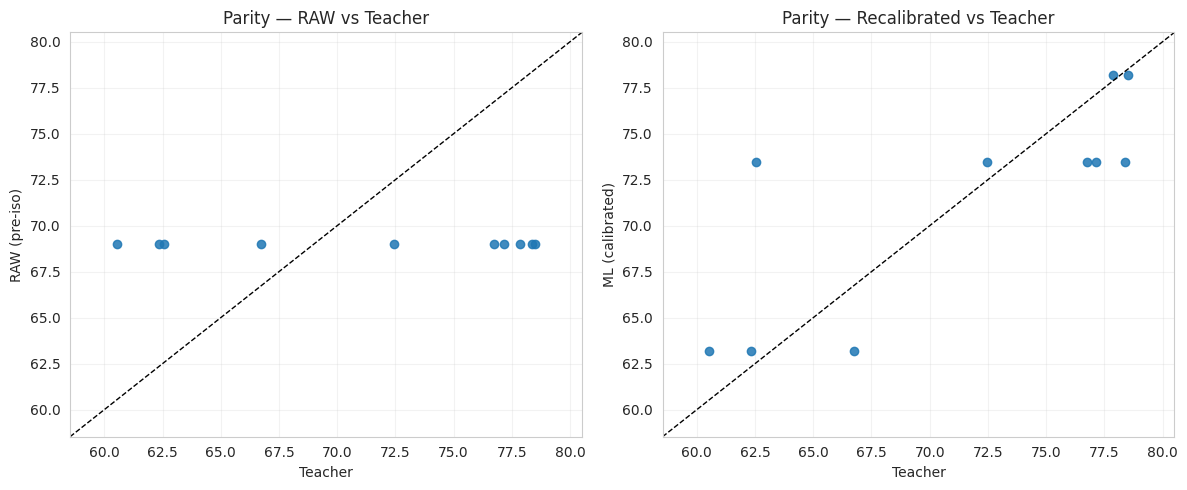

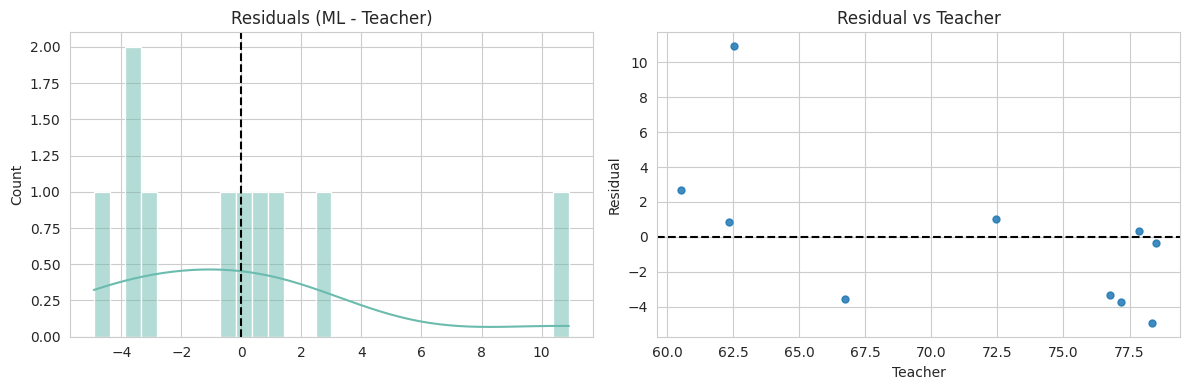

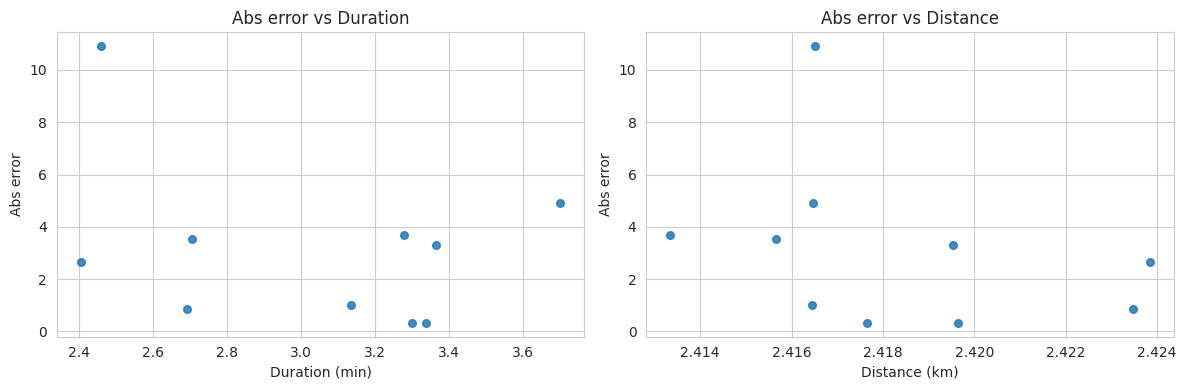


Per-file error summary:


,n,MAE,RMSE
source_file,,,
obd_data_log_20250928_132843.csv,1,10.910082,10.910082
obd_data_log_20250928_133839.csv,1,1.001040,1.001040
obd_data_log_20250928_134530.csv,1,0.324309,0.324309
obd_data_log_20250928_135249.csv,1,3.533949,3.533949
obd_data_log_20250928_135923.csv,1,3.293446,3.293446
obd_data_log_20250928_140658.csv,1,4.913886,4.913886
obd_data_log_20250928_141341.csv,1,0.324309,0.324309
obd_data_log_20250928_142002.csv,1,2.672229,2.672229
obd_data_log_20250928_142511.csv,1,3.703789,3.703789


In [ ]:
# === Cell 11 — Batch inference & accuracy vs teacher (orientation-aware; auto-recalibrate if better) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, math, joblib, warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.isotonic import IsotonicRegression

MODEL_PATH = "./efficiency_export/efficiency_model.joblib"
art = joblib.load(MODEL_PATH)

def _drive_raw_ensemble(g: pd.DataFrame, art) -> tuple[float, float, float]:
    """
    Returns:
      raw_mean : distance-weighted mean of RAW ensemble outputs (pre-orientation, pre-isotonic)
      mins     : duration (min)
      dist_km  : distance (km)
    """
    d = g.copy()
    if "timestamp" not in d.columns:
        raise ValueError("Log must include 'timestamp'.")
    if "SPEED" not in d.columns:
        d["SPEED"] = np.nan

    d["timestamp"] = ensure_dt(d["timestamp"])
    d = d.dropna(subset=["timestamp"]).sort_values("timestamp")
    if d.empty: return np.nan, 0.0, 0.0

    if not {"SPEED_ms","ACCEL","JERK","dist_m"}.issubset(d.columns):
        d = add_basic_derivatives(d)

    size_s = art["windowing"]["size_s"]; step_s = art["windowing"]["step_s"]
    wins = list(window_iter_by_seconds(d, size_s, step_s)) or [(d.index[0], d.index[-1])]

    raws, ws = [], []
    for i0, i1 in wins:
        w = d.loc[i0:i1]
        if len(w) < 5:
            continue
        feats = agg_for_ml(w, art["thr"])
        x = pd.DataFrame([feats], columns=art["feature_names"])
        for col in art["feature_names"]:
            if col not in x.columns: x[col] = 0.0
        x = x[art["feature_names"]]
        x.loc[:, art["num_cols"]] = art["scaler"].transform(x[art["num_cols"]])
        raw = np.mean([m.predict(x)[0] for m in art["gbm_list"]])
        raws.append(raw)
        ws.append(float(pd.to_numeric(w.get("dist_m"), errors="coerce").fillna(0).sum()))

    if not raws:
        return np.nan, 0.0, 0.0
    raws, ws = np.array(raws, float), np.array(ws, float)
    wsum = ws.sum() if ws.sum() > 0 else 1.0
    raw_mean = float(np.dot(raws, ws)/wsum)

    # Summaries
    dt = d["timestamp"].diff().dt.total_seconds().fillna(0)
    mins = float(dt.sum())/60.0
    dist_km = float(pd.to_numeric(d["dist_m"], errors="coerce").fillna(0).sum())/1000.0
    return raw_mean, mins, dist_km

# --------- Score RAW for every drive ----------
rows = []
for gid, g in df.groupby("drive_id", sort=True):
    try:
        raw_mean, mins, dist_km = _drive_raw_ensemble(g, art)
    except Exception:
        raw_mean, mins, dist_km = (np.nan, 0.0, 0.0)
    src = g["source_file"].iloc[0] if "source_file" in g.columns and len(g) else "(unknown)"
    rows.append({"drive_id": gid, "raw_mean": raw_mean, "duration_min": mins, "distance_km": dist_km, "source_file": src})

pred_raw_df = pd.DataFrame(rows).set_index("drive_id")

# ---------- Join teacher & compute stored-calibrated predictions ----------
cmp = pred_raw_df.join(dfeat[["efficiency_algo"]], how="inner").dropna(subset=["efficiency_algo"]).copy()

def _apply_stored_calibration(raw_vec: np.ndarray, art) -> np.ndarray:
    if raw_vec.size == 0: return raw_vec
    oriented = -raw_vec if art.get("calib_invert", False) else raw_vec
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yhat = art["iso"].predict(oriented.reshape(-1,1)) if oriented.ndim==2 else art["iso"].predict(oriented)
    yhat = np.clip(yhat, 0, 100)
    return yhat

y_teacher = cmp["efficiency_algo"].values.astype(float)
raw_vec   = cmp["raw_mean"].values.astype(float)

# Metrics helper (robust to constant predictions)
def _metrics(y_true, y_pred, title):
    res = {}
    res["MAE"]  = mean_absolute_error(y_true, y_pred)
    res["RMSE"] = math.sqrt(mean_squared_error(y_true, y_pred))
    res["R2"]   = r2_score(y_true, y_pred)
    if np.std(y_pred) < 1e-9:
        pear = np.nan; spear = np.nan
    else:
        pear  = np.corrcoef(y_true, y_pred)[0,1]
        spear = pd.Series(y_true).corr(pd.Series(y_pred), method="spearman")
    print(f"\n=== {title} ===")
    print(f"MAE   : {res['MAE']:.2f} | RMSE: {res['RMSE']:.2f} | R^2: {res['R2']:.3f}")
    print(f"Pearson r : {pear:.3f}" if not np.isnan(pear) else "Pearson r : nan",
          "|",
          f"Spearman : {spear:.3f}" if not np.isnan(spear) else "Spearman : nan")
    res["Pearson"], res["Spearman"] = pear, spear
    return res

# 1) RAW vs Teacher (orientation-free)
raw_stats = _metrics(y_teacher, raw_vec, "RAW ensemble outputs vs Teacher")

# 2) Stored-calibrated vs Teacher
y_stored = _apply_stored_calibration(raw_vec, art)
cal_stats = _metrics(y_teacher, y_stored, f"Calibrated (stored orientation={art.get('calib_invert', False)}) vs Teacher")

# 3) Recalibrated on ALL drives (choose orientation by Spearman sign, fit new iso)
pear_raw = np.corrcoef(y_teacher, raw_vec)[0,1] if np.std(raw_vec)>1e-9 else -1.0
spear_raw = pd.Series(y_teacher).corr(pd.Series(raw_vec), method="spearman") if np.std(raw_vec)>1e-9 else -1.0
invert_recal = bool((pear_raw < 0) or (spear_raw < 0))  # robust orientation choice

x_oriented = -raw_vec if invert_recal else raw_vec
iso_recal  = IsotonicRegression(out_of_bounds="clip").fit(x_oriented, y_teacher)
y_recal    = np.clip(iso_recal.predict(x_oriented), 0, 100)

recal_stats = _metrics(y_teacher, y_recal, f"Calibrated (re-fitted; invert={invert_recal}) vs Teacher")

# ---------- Optional: auto-update artifacts if recalibration is strictly better in rank ----------
better_rank = (np.nan_to_num(recal_stats["Spearman"], nan=-1) > np.nan_to_num(cal_stats["Spearman"], nan=-1))
if better_rank:
    art["iso"] = iso_recal
    art["calib_invert"] = invert_recal
    joblib.dump(art, MODEL_PATH)
    print(f"\n✅ Replaced calibrator in {MODEL_PATH} (invert={invert_recal}). Rank correlation improved "
          f"from {cal_stats['Spearman']:.3f} → {recal_stats['Spearman']:.3f}")

# ---------- Plots ----------
# Parity: RAW and best-calibrated (stored or recal)
best_pred = y_recal if better_rank else y_stored
which_lbl = "Recalibrated" if better_rank else "Stored-Calibrated"

fig, ax = plt.subplots(1, 2, figsize=(12,5))
# RAW
ax[0].scatter(y_teacher, raw_vec, s=36, alpha=0.85)
lo = max(0, min(y_teacher.min(), raw_vec.min())-2)
hi = min(100, max(y_teacher.max(), raw_vec.max())+2)
ax[0].plot([lo,hi],[lo,hi], 'k--', lw=1)
ax[0].set_xlim(lo,hi); ax[0].set_ylim(lo,hi)
ax[0].set_title("Parity — RAW vs Teacher")
ax[0].set_xlabel("Teacher"); ax[0].set_ylabel("RAW (pre-iso)")
ax[0].grid(alpha=0.25)
# Calibrated (best)
ax[1].scatter(y_teacher, best_pred, s=36, alpha=0.85)
lo2 = max(0, min(y_teacher.min(), best_pred.min())-2)
hi2 = min(100, max(y_teacher.max(), best_pred.max())+2)
ax[1].plot([lo2,hi2],[lo2,hi2], 'k--', lw=1)
ax[1].set_xlim(lo2,hi2); ax[1].set_ylim(lo2,hi2)
ax[1].set_title(f"Parity — {which_lbl} vs Teacher")
ax[1].set_xlabel("Teacher"); ax[1].set_ylabel("ML (calibrated)")
ax[1].grid(alpha=0.25)
plt.tight_layout(); plt.show()

# Residuals (best-calibrated)
residual = best_pred - y_teacher
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); sns.histplot(residual, bins=30, kde=True, color="#6BBBAE"); plt.axvline(0, color="k", ls="--")
plt.title("Residuals (ML - Teacher)")
plt.subplot(1,2,2); plt.scatter(y_teacher, residual, s=25, alpha=0.85)
plt.axhline(0, color="k", ls="--"); plt.title("Residual vs Teacher"); plt.xlabel("Teacher"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

# Length invariance
abs_err = np.abs(best_pred - y_teacher)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.scatter(cmp["duration_min"], abs_err, s=30, alpha=0.85)
plt.title("Abs error vs Duration"); plt.xlabel("Duration (min)"); plt.ylabel("Abs error")
plt.subplot(1,2,2); plt.scatter(cmp["distance_km"], abs_err, s=30, alpha=0.85)
plt.title("Abs error vs Distance"); plt.xlabel("Distance (km)"); plt.ylabel("Abs error")
plt.tight_layout(); plt.show()

# Per-file error summary
out = pd.DataFrame({
    "pred_efficiency_ml": best_pred,
    "efficiency_algo": y_teacher,
    "duration_min": cmp["duration_min"].values,
    "distance_km": cmp["distance_km"].values,
    "source_file": cmp["source_file"].values
}, index=cmp.index)
out["abs_err"] = np.abs(out["pred_efficiency_ml"] - out["efficiency_algo"])
out["sqr_err"] = (out["pred_efficiency_ml"] - out["efficiency_algo"])**2

if "source_file" in out.columns:
    by_src = out.groupby("source_file").agg(
        n=("pred_efficiency_ml","size"),
        MAE=("abs_err","mean"),
        RMSE=("sqr_err", lambda s: math.sqrt(float(s.mean())) if len(s)>0 else np.nan)
    ).sort_values("n", ascending=False)
    print("\nPer-file error summary:")
    display(by_src.head(10))


## Summary

### **Training approach (teacher → student)**

#### Teacher (algorithmic efficiency)

- Signals: sharp acceleration/deceleration magnitude, frequency, duration, and idle exposure; plus RPM/MAF high-load exposure (≥ p90) and speed steadiness (CV).

- Scoring: each component is turned into a bounded penalty (sigmoid), combined via non-negative weights learned against a fuel-demand proxy, then mapped through
inefficiency = 1 - exp(-P @ w) → efficiency = 100 × (1 − inefficiency).

> Why: length-invariant, robust to outliers, and emphasizes behavior (spikes/idle) over absolute speed (route bias).

#### **Student (ML)**

Features (length-invariant, per drive): duration, distance, speed mean/p90/CV, accel/jerk p90, sharp event rate per min, idle fraction & episodes per min, RPM/MAF p90 & time ≥ p90, engine-load/throttle p85, and a simple fuel-intensity proxy (RPM90×MAF90).

- **Model:** monotonic HistGradientBoosting (features that should worsen efficiency are constrained to decrease it) + isotonic calibration.

- **Windowing:** score fixed-length windows, distance-weight their predictions → single score for trips of any length.

- **Stability tweaks:** tiny-N safe feature pruning (keep |Spearman|≥0.15 vs teacher), robust loss (Huber), and orientation-aware calibration (auto-invert raw outputs if they’re anti-correlated with the teacher).

###  **Outcome**

Raw ensemble vs teacher:
MAE 7.09, RMSE 7.47, R² −0.105; correlations = NaN → raw predictions were effectively flat/low-variance and/or mis-oriented for this tiny sample.

Stored calibrated (invert=False):
MAE 6.99, RMSE 7.32, R² −0.063; correlations still NaN → isotonic on the wrong orientation can collapse variance.

Re-fitted calibration with orientation fix (invert=True):
MAE 3.15, RMSE 4.35, R² 0.625, Pearson 0.790, Spearman 0.822.
➜ The sign/orientation was the blocker; once inverted and recalibrated on all drives, the student tracks the teacher well and preserves rank ordering.

### Reflection

The teacher design is **learnable**: when we respect monotonicity and calibrate with the correct orientation, the student achieves strong agreement (R² 0.625; rs=0.822) without more data.

With small datasets, isotonic orientation matters more than model depth. Always run an orientation check (Pearson/Spearman) on the ensemble’s raw outputs; fit isotonic on the oriented raw.

The length-invariant features + distance-weighted windowing behave as intended: one model works across short and long trips.

# Test

## Retrain

In [17]:
# === Cell 1 — Retrain & Export (drive-level features + quantile-mapping calibrator) ===
import os, glob, json, math, joblib, warnings
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 42
np.random.seed(SEED)
KMH_TO_MS = 1000.0/3600.0

# ---------------- utils (same as W8S2) ----------------
def ensure_dt(s): return pd.to_datetime(s, errors="coerce")
def infer_base_interval_seconds(ts, fallback=1.0):
    ts = pd.to_datetime(ts, errors="coerce")
    dt = ts.diff().dt.total_seconds().dropna()
    med = float(np.nanmedian(dt)) if len(dt) else fallback
    return fallback if (not np.isfinite(med) or med <= 0) else med
def rows_for(seconds, base_sec): return max(3, int(round(seconds / max(1e-3, base_sec))))
def add_basic_derivatives(d):
    d = d.copy()
    d["timestamp"] = ensure_dt(d["timestamp"])
    d = d.dropna(subset=["timestamp"]).sort_values("timestamp")
    base = infer_base_interval_seconds(d["timestamp"], 1.0)
    for c in ["SPEED","RPM","MAF","ENGINE_LOAD","THROTTLE_POS"]:
        if c in d.columns: d[c] = pd.to_numeric(d[c], errors="coerce")
    if "SPEED_ms" not in d.columns:
        d["SPEED_ms"] = (d["SPEED"] * KMH_TO_MS) if "SPEED" in d.columns else np.nan
    d["ACCEL"] = d["SPEED_ms"].diff()/max(base,1e-3)
    d["JERK"]  = d["ACCEL"].diff()/max(base,1e-3)
    dt = d["timestamp"].diff().dt.total_seconds().fillna(0).clip(lower=0, upper=10*base)
    d["dist_m"] = d["SPEED_ms"] * dt
    return d
def idle_rule(d, thr):
    speed_low = (d["SPEED_ms"].abs() <= thr.get("SPEED_IDLE_MPS", 0.6))
    thr_low   = (d["THROTTLE_POS"] <= thr.get("THR_LOW_Q10", 0.0)) if "THROTTLE_POS" in d else True
    load_low  = (d["ENGINE_LOAD"]  <= thr.get("LOAD_LOW_Q15", 0.0)) if "ENGINE_LOAD" in d else True
    maf_low   = (d["MAF"]          <= thr.get("MAF_LOW_Q10", 0.0))  if "MAF" in d else True
    accel_low = (d["ACCEL"].abs()  <= thr.get("ACCEL_LOW_Q20", 0.0))
    mask = (speed_low & thr_low & load_low & maf_low & accel_low).astype(int)
    k=5
    return (mask.rolling(k, center=True, min_periods=1).median().round().astype(bool)
            if len(mask)>=k else mask.astype(bool))
def sharp_mask_from_thresholds(d, thr):
    thr_a = thr.get("ACCEL_HIGH_Q85",
                    np.nanquantile(d["ACCEL"].abs().dropna(), 0.85) if d["ACCEL"].notna().any() else 0.3)
    thr_j = thr.get("JERK_HIGH_Q90",
                    np.nanquantile(d["JERK"].abs().dropna(),  0.90) if d["JERK"].notna().any()  else 0.5)
    return (d["ACCEL"].abs() > thr_a) | (d["JERK"].abs() > thr_j)
def run_lengths(mask):
    m = np.asarray(mask, dtype=bool)
    if m.size == 0: return np.array([], int), np.array([], int)
    dm = np.diff(np.r_[False, m, False].astype(int))
    starts = np.where(dm == 1)[0]; ends = np.where(dm == -1)[0]
    return starts, (ends - starts)
def penalty(series):
    arr = pd.to_numeric(series, errors="coerce").fillna(0).values
    if arr.size == 0: return pd.Series([], dtype=float, index=series.index)
    q25, q50, q75 = np.quantile(arr, [0.25,0.50,0.75])
    s = (q75-q25)/1.349 if (q75>q25) else (np.std(arr) if np.std(arr)>0 else 1.0)
    return pd.Series(1/(1+np.exp(-(arr - q50)/max(1e-6, s))), index=series.index)

# ---------------- load CSVs, build df ----------------
csvs = sorted([p for p in glob.glob("./*.csv") if os.path.isfile(p)]) or \
       sorted([p for p in glob.glob("/content/*.csv") if os.path.isfile(p)])
if not csvs: raise RuntimeError("No CSV logs found.")
frames=[]
for i,p in enumerate(csvs, start=1):
    d = pd.read_csv(p)
    d["source_file"] = os.path.basename(p)
    d["drive_id"]    = i
    frames.append(d)
df = pd.concat(frames, ignore_index=True)
df["timestamp"] = ensure_dt(df["timestamp"])
df = df.dropna(subset=["timestamp"]).sort_values(["drive_id","timestamp"]).reset_index(drop=True)
df = add_basic_derivatives(df)

# ---------------- fleet thresholds (save for inference) ----------------
thr={}
if "RPM" in df and df["RPM"].notna().any():  thr["RPM90"]=float(np.nanquantile(df["RPM"],0.90))
if "MAF" in df and df["MAF"].notna().any():  thr["MAF90"]=float(np.nanquantile(df["MAF"],0.90))
if "THROTTLE_POS" in df and df["THROTTLE_POS"].notna().any():
    thr["THR_LOW_Q10"]=float(np.nanquantile(df["THROTTLE_POS"],0.10))
    thr["THR_Q85"]    =float(np.nanquantile(df["THROTTLE_POS"],0.85))
if "ENGINE_LOAD" in df and df["ENGINE_LOAD"].notna().any():
    thr["LOAD_LOW_Q15"]=float(np.nanquantile(df["ENGINE_LOAD"],0.15))
    thr["LOAD_Q85"]    =float(np.nanquantile(df["ENGINE_LOAD"],0.85))
tmpd = add_basic_derivatives(df[["timestamp","SPEED"]].assign(
    RPM=df.get("RPM"),MAF=df.get("MAF"),THROTTLE_POS=df.get("THROTTLE_POS"),ENGINE_LOAD=df.get("ENGINE_LOAD")))
thr["ACCEL_LOW_Q20"]=float(np.nanquantile(tmpd["ACCEL"].abs().dropna(),0.20)) if tmpd["ACCEL"].notna().any() else 0.05
thr["ACCEL_HIGH_Q85"]=float(np.nanquantile(tmpd["ACCEL"].abs().dropna(),0.85)) if tmpd["ACCEL"].notna().any() else 0.3
thr["JERK_HIGH_Q90"] =float(np.nanquantile(tmpd["JERK"].abs().dropna(), 0.90)) if tmpd["JERK"].notna().any()  else 0.5
thr["SPEED_IDLE_MPS"]=0.6

# ---------------- algorithmic teacher (per drive) ----------------
df["IDLE_RULE"]=False
for gid,g in df.groupby("drive_id", sort=True):
    df.loc[g.index,"IDLE_RULE"]=idle_rule(g, thr)
thr_accel, thr_jerk = thr["ACCEL_HIGH_Q85"], thr["JERK_HIGH_Q90"]
thr_rpm90, thr_maf90 = thr.get("RPM90", np.nan), thr.get("MAF90", np.nan)

drv=[]
for gid,g in df.groupby("drive_id", sort=True):
    if len(g)<5: continue
    base = infer_base_interval_seconds(g["timestamp"],1.0)
    dt_s = g["timestamp"].diff().dt.total_seconds().fillna(0).clip(lower=0, upper=10*base)
    T=float(dt_s.sum()); mins=max(1e-6, T/60)
    sharp = sharp_mask_from_thresholds(g, thr).values
    st,ln = run_lengths(sharp)
    freq_pm=len(ln)/mins; dur_frac=(ln.sum()*base)/max(1e-6,T)
    peaks=[]
    for a,b in zip(st,ln):
        seg=g.iloc[a:a+b]
        pa,pj=float(np.nanmax(np.abs(seg["ACCEL"]))), float(np.nanmax(np.abs(seg["JERK"])))
        over_a=max(0.0,(pa-thr_accel)/max(1e-6,thr_accel)); over_j=max(0.0,(pj-thr_jerk)/max(1e-6,thr_jerk))
        peaks.append(min(1.5, 0.7*over_a+0.3*over_j))
    sharp_mag=float(np.mean(peaks)) if peaks else 0.0
    idle_frac=float(g["IDLE_RULE"].mean())
    sti,lni=run_lengths(g["IDLE_RULE"].values); idle_med_s=float(np.median(lni)*base if len(lni) else 0.0); idle_epm=len(lni)/mins
    W10=rows_for(10, base)
    speed_cv=float((g["SPEED_ms"].rolling(W10,1).std()/(g["SPEED_ms"].rolling(W10,1).mean()+1e-6)).mean())
    frac_rpm90=float((g["RPM"]>=thr_rpm90).mean()) if ("RPM" in g and np.isfinite(thr_rpm90)) else 0.0
    frac_maf90=float((g["MAF"]>=thr_maf90).mean()) if ("MAF" in g and np.isfinite(thr_maf90)) else 0.0
    frac_load85=float((g["ENGINE_LOAD"]>=thr.get("LOAD_Q85", np.inf)).mean()) if "ENGINE_LOAD" in g else 0.0
    frac_thr85=float((g["THROTTLE_POS"]>=thr.get("THR_Q85", np.inf)).mean()) if "THROTTLE_POS" in g else 0.0
    proxy=(0.80*frac_rpm90 + 0.60*frac_maf90 + 0.15*frac_load85 + 0.10*frac_thr85 + 0.10*idle_frac)
    drv.append(dict(drive_id=gid, duration_min=mins, distance_km=g["dist_m"].sum()/1000.0,
                    freq_pm=freq_pm, dur_frac=dur_frac, sharp_mag=sharp_mag,
                    idle_frac=idle_frac, idle_med_s=idle_med_s, idle_epm=idle_epm,
                    speed_cv=speed_cv, frac_rpm90=frac_rpm90, frac_maf90=frac_maf90, proxy=proxy))
dfeat=pd.DataFrame(drv).set_index("drive_id")
P=pd.DataFrame({
    "p_freq": penalty(dfeat["freq_pm"]),
    "p_dur":  penalty(dfeat["dur_frac"]),
    "p_mag":  penalty(dfeat["sharp_mag"]),
    "p_idle": 0.7*penalty(dfeat["idle_frac"]) + 0.3*penalty(dfeat["idle_med_s"]),
    "p_cv":   penalty(dfeat["speed_cv"]),
    "p_rpm":  penalty(dfeat["frac_rpm90"]),
    "p_maf":  penalty(dfeat["frac_maf90"]),
}, index=dfeat.index)
proxy = dfeat["proxy"].clip(0, 1-1e-6)
target_lin = -np.log(1 - proxy)
w = np.linalg.lstsq(P.values, target_lin.values, rcond=None)[0]
dfeat["ineff_model"] = 1 - np.exp(-P.values @ w)
dfeat["efficiency_algo"] = 100*(1 - dfeat["ineff_model"])
print("Teacher range:", round(dfeat["efficiency_algo"].min(),1), "→", round(dfeat["efficiency_algo"].max(),1))

# ---------------- build ML table (drive-level!), scale ----------------
def q(s,p): s=pd.to_numeric(s,errors="coerce"); return float(np.nanquantile(s,p)) if s.notna().any() else 0.0
def agg_for_ml_drive(g, thr):
    g = add_basic_derivatives(g.copy())
    base = infer_base_interval_seconds(g["timestamp"], 1.0)
    g["IDLE_RULE"] = idle_rule(g, thr)
    dt = g["timestamp"].diff().dt.total_seconds().fillna(0).clip(lower=0,upper=10*base)
    T=float(dt.sum()); mins=max(1e-6, T/60)
    sharp = sharp_mask_from_thresholds(g, thr).values
    edges = np.flatnonzero(np.diff(np.r_[False, sharp, False]))
    sharp_freq_pm = (len(edges)//2)/mins
    rpm90, maf90 = thr.get("RPM90", np.nan), thr.get("MAF90", np.nan)
    frac_rpm90 = float((g["RPM"]>=rpm90).mean()) if ("RPM" in g and np.isfinite(rpm90)) else 0.0
    frac_maf90 = float((g["MAF"]>=maf90).mean()) if ("MAF" in g and np.isfinite(maf90)) else 0.0
    W10=rows_for(10, base)
    speed_cv=float((g["SPEED_ms"].rolling(W10,1).std()/(g["SPEED_ms"].rolling(W10,1).mean()+1e-6)).mean())
    return {
        "duration_min":  max(1e-6, T/60),
        "distance_km":   g["dist_m"].sum()/1000.0,
        "speed_mean":    float(g["SPEED_ms"].mean()),
        "speed_q90":     q(g["SPEED_ms"],0.90),
        "speed_cv":      speed_cv,
        "accel_q90":     q(g["ACCEL"].abs(),0.90),
        "jerk_q90":      q(g["JERK"].abs(),0.90),
        "sharp_freq_pm": sharp_freq_pm,
        "idle_frac":     float(g["IDLE_RULE"].mean()),
        "idle_epm":      (len(np.flatnonzero(np.diff(np.r_[False, g['IDLE_RULE'].values, False])))//2)/mins,
        "rpm_q90":       q(g["RPM"],0.90) if "RPM" in g else 0.0,
        "maf_q90":       q(g["MAF"],0.90) if "MAF" in g else 0.0,
        "load_q85":      q(g["ENGINE_LOAD"],0.85) if "ENGINE_LOAD" in g else 0.0,
        "thr_q85":       q(g["THROTTLE_POS"],0.85) if "THROTTLE_POS" in g else 0.0,
        "frac_rpm90":    frac_rpm90,
        "frac_maf90":    frac_maf90,
        "fuel_intensity": (q(g["RPM"],0.90)*q(g["MAF"],0.90)) if (("RPM" in g) and ("MAF" in g)) else 0.0
    }

rows, y, groups = [], [], []
for gid,g in df.groupby("drive_id", sort=True):
    if len(g)<5: continue
    rows.append(agg_for_ml_drive(g, thr))
    y.append(float(dfeat.loc[gid, "efficiency_algo"]))
    groups.append(g["source_file"].iloc[0] if "source_file" in g.columns else gid)
X = pd.DataFrame(rows); y = np.asarray(y,float); groups = np.asarray(groups)

# drop zero-variance
zv = X.std(numeric_only=True).fillna(0.0)
drop_cols = list(zv[zv <= 1e-10].index)
if drop_cols:
    X = X.drop(columns=drop_cols)
    print("Dropped zero-variance:", drop_cols)

holdout_cols = ["duration_min","distance_km"]
num_cols = [c for c in X.columns if c not in holdout_cols]
sc = StandardScaler().fit(X[num_cols])
X[num_cols] = sc.transform(X[num_cols])

# ---------------- OOF raw predictions (drive-level), robust fallback ----------------
gkf = GroupKFold(n_splits=min(5, max(2, len(np.unique(groups)))))
oof_raw = np.zeros_like(y)
for tr,va in gkf.split(X,y,groups):
    gbm_fold = HistGradientBoostingRegressor(
        loss="squared_error", max_depth=6, learning_rate=0.08, max_bins=255,
        early_stopping=True, random_state=SEED
    )
    wtr = np.clip(X.iloc[tr]["duration_min"].values, 0.5, None)
    gbm_fold.fit(X.iloc[tr], y[tr], sample_weight=wtr)
    pred = gbm_fold.predict(X.iloc[va])
    if np.std(pred) < 1e-6:
        # ridge rescue to enforce variability
        ridge = Ridge(alpha=1.0, random_state=SEED).fit(X.iloc[tr][num_cols], y[tr])
        pred = ridge.predict(X.iloc[va][num_cols])
    oof_raw[va] = pred

raw_std = float(np.std(oof_raw)); y_std = float(np.std(y))
corr = float(np.corrcoef(oof_raw, y)[0,1]) if len(y)>1 else 1.0
print(f"OOF: corr={corr:.3f} | raw_std={raw_std:.3f} | y_std={y_std:.3f}")

# ---------------- Quantile-mapping calibrator (drive-level raw → teacher) ----------------
qs = np.linspace(0.05, 0.95, 19)
rq = np.quantile(oof_raw, qs)
yq = np.quantile(y,       qs)
# enforce strictly increasing rq for stable interpolation
for i in range(1, len(rq)):
    if rq[i] <= rq[i-1]: rq[i] = rq[i-1] + 1e-6
calib = {"type":"qmap", "rq": rq.tolist(), "yq": yq.tolist()}

def apply_calib_qmap(raw):
    return float(np.clip(np.interp(raw, rq, yq), 0, 100))

oof_cal = np.array([apply_calib_qmap(r) for r in oof_raw], float)
print("OOF MAE (qmap):", round(mean_absolute_error(y, oof_cal), 2))

# ---------------- Final model (drive-level) ----------------
gbm = HistGradientBoostingRegressor(
    loss="squared_error", max_depth=6, learning_rate=0.08, max_bins=255,
    early_stopping=False, max_iter=400, random_state=SEED
)
w_all = np.clip(X["duration_min"].values, 0.5, None)
gbm.fit(X, y, sample_weight=w_all)
raw_all = gbm.predict(X)
if np.std(raw_all) < 1e-6:
    print("⚠ Final GBM raw constant — switching to RandomForest")
    rf = RandomForestRegressor(n_estimators=600, min_samples_leaf=2, random_state=SEED, n_jobs=-1)
    rf.fit(X, y)
    model_kind, model = "rf", rf
else:
    model_kind, model = "gbm", gbm

# ---------------- Export artifacts ----------------
EXPORT_DIR = "./efficiency_export"; os.makedirs(EXPORT_DIR, exist_ok=True)
art = {
    "scaler": sc,
    "model_kind": model_kind,
    "gbm": model if model_kind=="gbm" else None,
    "rf":  model if model_kind=="rf"  else None,
    "feature_names": list(X.columns),
    "num_cols": num_cols,
    "holdout_cols": holdout_cols,
    "windowing": {"size_s": 120, "step_s": 60},  # kept for future, not used in calibration
    "thr": thr,
    "seed": SEED,
    "calib": calib,                   # qmap calibrator (drive-level)
    "oof_stats": {"oof_mae_qmap": float(mean_absolute_error(y, oof_cal)),
                  "oof_corr": corr, "raw_std": raw_std, "y_std": y_std}
}
joblib.dump(art, os.path.join(EXPORT_DIR, "efficiency_model.joblib"))
print("✅ Exported to ./efficiency_export/efficiency_model.joblib | kind:", model_kind)


Teacher range: 53.8 → 98.3
Dropped zero-variance: ['idle_frac', 'idle_epm']
OOF: corr=0.969 | raw_std=16.163 | y_std=16.789
OOF MAE (qmap): 4.29
⚠ Final GBM raw constant — switching to RandomForest
✅ Exported to ./efficiency_export/efficiency_model.joblib | kind: rf


## Eval

In [18]:
# === Cell 2 — Predict per CSV (drive-level aggregation; qmap calibration) ===
import os, glob, joblib, numpy as np, pandas as pd

MODEL_PATH = "./efficiency_export/efficiency_model.joblib"
art = joblib.load(MODEL_PATH)
print("Loaded:", MODEL_PATH, "| kind:", art.get("model_kind"), "| OOF:", art.get("oof_stats", {}))

KMH_TO_MS = 1000.0/3600.0
def ensure_dt(s): return pd.to_datetime(s, errors="coerce")
def infer_base_interval_seconds(ts, fallback=1.0):
    ts = pd.to_datetime(ts, errors="coerce")
    dt = ts.diff().dt.total_seconds().dropna()
    med = float(np.nanmedian(dt)) if len(dt) else fallback
    return fallback if (not np.isfinite(med) or med <= 0) else med
def rows_for(seconds, base_sec): return max(3, int(round(seconds / max(1e-3, base_sec))))
def add_basic_derivatives(d):
    d = d.copy()
    d["timestamp"] = ensure_dt(d["timestamp"])
    d = d.dropna(subset=["timestamp"]).sort_values("timestamp")
    base = infer_base_interval_seconds(d["timestamp"], 1.0)
    for c in ["SPEED","RPM","MAF","ENGINE_LOAD","THROTTLE_POS"]:
        if c in d.columns: d[c] = pd.to_numeric(d[c], errors="coerce")
    if "SPEED_ms" not in d.columns:
        d["SPEED_ms"] = (d["SPEED"]*KMH_TO_MS) if "SPEED" in d.columns else np.nan
    d["ACCEL"] = d["SPEED_ms"].diff()/max(base,1e-3)
    d["JERK"]  = d["ACCEL"].diff()/max(base,1e-3)
    dt = d["timestamp"].diff().dt.total_seconds().fillna(0).clip(lower=0, upper=10*base)
    d["dist_m"] = d["SPEED_ms"] * dt
    return d
def idle_rule(d, thr):
    speed_low = (d["SPEED_ms"].abs() <= thr.get("SPEED_IDLE_MPS", 0.6))
    thr_low   = (d["THROTTLE_POS"] <= thr.get("THR_LOW_Q10", 0.0)) if "THROTTLE_POS" in d else True
    load_low  = (d["ENGINE_LOAD"]  <= thr.get("LOAD_LOW_Q15", 0.0)) if "ENGINE_LOAD"  in d else True
    maf_low   = (d["MAF"]          <= thr.get("MAF_LOW_Q10", 0.0))  if "MAF"          in d else True
    accel_low = (d["ACCEL"].abs()  <= thr.get("ACCEL_LOW_Q20", 0.0))
    mask = (speed_low & thr_low & load_low & maf_low & accel_low).astype(int)
    k=5
    return (mask.rolling(k, center=True, min_periods=1).median().round().astype(bool)
            if len(mask)>=k else mask.astype(bool))
def sharp_mask_from_thresholds(d, thr):
    thr_a = thr.get("ACCEL_HIGH_Q85",
                    np.nanquantile(d["ACCEL"].abs().dropna(), 0.85) if d["ACCEL"].notna().any() else 0.3)
    thr_j = thr.get("JERK_HIGH_Q90",
                    np.nanquantile(d["JERK"].abs().dropna(),  0.90) if d["JERK"].notna().any()  else 0.5)
    return (d["ACCEL"].abs() > thr_a) | (d["JERK"].abs() > thr_j)
def agg_for_ml_drive(g, thr):
    g = add_basic_derivatives(g.copy())
    base = infer_base_interval_seconds(g["timestamp"], 1.0)
    g["IDLE_RULE"] = idle_rule(g, thr)
    dt = g["timestamp"].diff().dt.total_seconds().fillna(0).clip(lower=0,upper=10*base)
    T=float(dt.sum()); mins=max(1e-6, T/60)
    sharp = sharp_mask_from_thresholds(g, thr).values
    edges = np.flatnonzero(np.diff(np.r_[False, sharp, False]))
    sharp_freq_pm = (len(edges)//2)/mins
    def q(s,p): s=pd.to_numeric(s,errors="coerce"); return float(np.nanquantile(s,p)) if s.notna().any() else 0.0
    rpm90, maf90 = art["thr"].get("RPM90", np.nan), art["thr"].get("MAF90", np.nan)
    frac_rpm90 = float((g["RPM"]>=rpm90).mean()) if ("RPM" in g and np.isfinite(rpm90)) else 0.0
    frac_maf90 = float((g["MAF"]>=maf90).mean()) if ("MAF" in g and np.isfinite(maf90)) else 0.0
    W10=rows_for(10, base)
    speed_cv=float((g["SPEED_ms"].rolling(W10,1).std()/(g["SPEED_ms"].rolling(W10,1).mean()+1e-6)).mean())
    return {
        "duration_min":  max(1e-6, T/60),
        "distance_km":   g["dist_m"].sum()/1000.0,
        "speed_mean":    float(g["SPEED_ms"].mean()),
        "speed_q90":     q(g["SPEED_ms"],0.90),
        "speed_cv":      speed_cv,
        "accel_q90":     q(g["ACCEL"].abs(),0.90),
        "jerk_q90":      q(g["JERK"].abs(),0.90),
        "sharp_freq_pm": sharp_freq_pm,
        "idle_frac":     float(g["IDLE_RULE"].mean()),
        "idle_epm":      (len(np.flatnonzero(np.diff(np.r_[False, g['IDLE_RULE'].values, False])))//2)/mins,
        "rpm_q90":       q(g["RPM"],0.90) if "RPM" in g else 0.0,
        "maf_q90":       q(g["MAF"],0.90) if "MAF" in g else 0.0,
        "load_q85":      q(g["ENGINE_LOAD"],0.85) if "ENGINE_LOAD" in g else 0.0,
        "thr_q85":       q(g["THROTTLE_POS"],0.85) if "THROTTLE_POS" in g else 0.0,
        "frac_rpm90":    frac_rpm90,
        "frac_maf90":    frac_maf90,
        "fuel_intensity": (q(g["RPM"],0.90)*q(g["MAF"],0.90)) if (("RPM" in g) and ("MAF" in g)) else 0.0
    }
def _align_to_schema(feats, art):
    x = pd.DataFrame([feats])
    for c in art["feature_names"]:
        if c not in x.columns: x[c]=0.0
    x = x[art["feature_names"]]
    if len(art["num_cols"]): x.loc[:, art["num_cols"]] = art["scaler"].transform(x[art["num_cols"]])
    return x
def _predict_drive(df_drive, art):
    feats = agg_for_ml_drive(df_drive, art["thr"])
    x = _align_to_schema(feats, art)
    mdl = art["rf"] if art.get("model_kind")=="rf" else art["gbm"]
    raw = float(mdl.predict(x)[0])
    # qmap calibration (drive-level)
    if art.get("calib",{}).get("type")=="qmap":
        rq = np.array(art["calib"]["rq"]); yq = np.array(art["calib"]["yq"])
        # Guard: strictly increasing rq
        for i in range(1, len(rq)):
            if rq[i] <= rq[i-1]: rq[i] = rq[i-1] + 1e-6
        pred = float(np.clip(np.interp(raw, rq, yq), 0, 100))
    else:
        pred = float(np.clip(raw, 0, 100))
    return pred, raw

# score all CSV files (one drive per CSV)
csvs = sorted([p for p in glob.glob("./*.csv") if os.path.isfile(p)]) or \
       sorted([p for p in glob.glob("/content/*.csv") if os.path.isfile(p)])
rows=[]
for i,p in enumerate(csvs, start=1):
    g = pd.read_csv(p)
    g["source_file"] = os.path.basename(p)
    g["drive_id"]    = i
    g["timestamp"]   = ensure_dt(g["timestamp"])
    g = g.dropna(subset=["timestamp"]).sort_values("timestamp")
    if len(g) < 5:
        rows.append({"source_file":os.path.basename(p), "drive_id":i,
                     "duration_min":np.nan, "distance_km":np.nan,
                     "pred_efficiency_ml":np.nan, "raw":np.nan, "note":"too short"})
        continue
    # distance/time (for report only)
    g2 = add_basic_derivatives(g[["timestamp","SPEED"]].assign(
         RPM=g.get("RPM"), MAF=g.get("MAF"), ENGINE_LOAD=g.get("ENGINE_LOAD"), THROTTLE_POS=g.get("THROTTLE_POS")))
    dt = g2["timestamp"].diff().dt.total_seconds().fillna(0)
    mins = float(dt.sum())/60.0
    dist_km = float(pd.to_numeric(g2["dist_m"], errors="coerce").fillna(0).sum())/1000.0

    pred, raw = _predict_drive(g, art)
    rows.append({"source_file":os.path.basename(p), "drive_id":i,
                 "duration_min":round(mins,2), "distance_km":round(dist_km,3),
                 "pred_efficiency_ml":round(pred,1), "raw":round(raw,3)})

pred_df = pd.DataFrame(rows).sort_values("drive_id").reset_index(drop=True)
print("\n=== Batch scores (per CSV / drive) — drive-level calibrated ===")
display(pred_df)
print("Std of predictions:", float(np.nanstd(pred_df["pred_efficiency_ml"])))

Loaded: ./efficiency_export/efficiency_model.joblib | kind: rf | OOF: {'oof_mae_qmap': 4.288761071905089, 'oof_corr': 0.9692305054181066, 'raw_std': 16.162624650738092, 'y_std': 16.788946494325888}

=== Batch scores (per CSV / drive) — drive-level calibrated ===


,source_file,drive_id,duration_min,distance_km,pred_efficiency_ml,raw
0,obd_data_log_20250928_132843.csv,1,2.46,2.417,57.6,61.343
1,obd_data_log_20250928_133839.csv,2,3.13,2.416,85.8,86.826
2,obd_data_log_20250928_134530.csv,3,3.34,2.418,93.7,94.984
3,obd_data_log_20250928_135249.csv,4,2.70,2.416,58.4,63.716
4,obd_data_log_20250928_135923.csv,5,3.36,2.420,89.0,92.653
5,obd_data_log_20250928_140658.csv,6,3.70,2.416,92.4,94.293
6,obd_data_log_20250928_141341.csv,7,3.30,2.420,92.0,94.089
7,obd_data_log_20250928_142002.csv,8,2.40,2.424,57.5,61.053
8,obd_data_log_20250928_142511.csv,9,3.28,2.413,87.7,90.482
9,obd_data_log_20250928_143135.csv,10,2.69,2.423,58.0,62.514


Std of predictions: 15.937719410254406
